# Capital Bike Share Project

### Index
1.  [Load & Clean Data](#1)<br>
2.  [EDA](#2)<br>
3.  [headline3](#3)<br>
4.  [headline4](#4)<br>
5.  [headline5](#5)<br>

# 1: Load & Clean Data<a id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

from geopy.distance import geodesic


In [2]:
# load data

df = pd.read_csv('CBS_2021-2023_Full.csv.', sep=',', header=0, low_memory=False).copy()
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member
1,629E059504606547,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111.0,NaN,NaN,38.917193,-77.025894,38.960000,-77.020000,casual
2,E74069873161EE33,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member
3,91F95E512CABC46A,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member
4,DA46A05139C0EA2F,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651.0,14th & Newton St NW,31649.0,38.931322,-77.028247,38.931991,-77.032956,member


In [3]:
df.shape

(10693997, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693997 entries, 0 to 10693996
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 1.0+ GB


In [5]:
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      811282
end_station_id        811282
start_lat                  2
start_lng                  2
end_lat                16765
end_lng                16765
member_casual              0
dtype: int64

* the nan values at station_name and station_id columns are likely to be the bikes which werent picked to a station or from a station 
* but 2 rows with no start_lat or start_long value should be removed.

In [6]:
df = df.dropna(subset=['start_lat', 'start_lng'])
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      811282
end_station_id        811282
start_lat                  0
start_lng                  0
end_lat                16763
end_lng                16763
member_casual              0
dtype: int64

In [7]:
# check for duplicates
df.duplicated().sum()

0

In [8]:
# drop ride_id columns since I can use index for each rides
df = df.drop(columns=['ride_id'])

In [9]:
# check for duplicates again
df.duplicated().sum()

634

* We have 634 duplicated entries after removing the ride_id column. Since it is unlikely to have multiple rides at the exact same time with the exact same location details down to the second and meters, I am removing these duplicates.

In [10]:
#drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693361 entries, 0 to 10693360
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   rideable_type       object 
 1   started_at          object 
 2   ended_at            object 
 3   start_station_name  object 
 4   start_station_id    object 
 5   end_station_name    object 
 6   end_station_id      object 
 7   start_lat           float64
 8   start_lng           float64
 9   end_lat             float64
 10  end_lng             float64
 11  member_casual       object 
dtypes: float64(4), object(8)
memory usage: 979.0+ MB


In [11]:
df.duplicated().sum()

0

In [12]:
df['started_at'] = pd.to_datetime(df['started_at'])

df['ended_at'] = pd.to_datetime(df['ended_at'])

In [13]:
# create trip_duration column 

df['trip_duration'] = df['ended_at'] - df['started_at']
df['trip_duration'] = df['trip_duration'].dt.total_seconds() / 60
df['trip_duration'] = df['trip_duration'].round(0).astype(int)
df.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member,25
1,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111.0,NaN,NaN,38.917193,-77.025894,38.960000,-77.020000,casual,16
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member,14
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member,6
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651.0,14th & Newton St NW,31649.0,38.931322,-77.028247,38.931991,-77.032956,member,3


* i will continue with reviewing each column and start with first colum rideable_type

In [14]:
df['rideable_type'].unique()

array(['classic_bike', 'electric_bike', 'docked_bike'], dtype=object)

In [15]:
df['rideable_type'].value_counts()

rideable_type
classic_bike     7709818
electric_bike    2444149
docked_bike       539394
Name: count, dtype: int64

* classic bikes are used for most of the rides with percentages follows:
* Classic Bike: 72.1%
* Electric Bike: 22.9%
* Docked Bike: 5.0%

In [16]:
df['rideable_type'] = df['rideable_type'].astype('category')

In [17]:
df['start_station_name'].nunique()

859

In [18]:
# change data type of station_id to integer

df['start_station_id'] = df['start_station_id'].astype(float).astype('Int64')

df.dtypes

rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id               Int64
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
trip_duration                  int32
dtype: object

In [19]:
df['start_station_id'].nunique()

773

* there is a difference between number of unique station names and station ids, which we need to resolve  
* The reason can be that a name has multiple id numbers

In [20]:
# Group by 'start_station_name' and get the unique 'start_station_id' for each station
start_station_ids = df.groupby('start_station_name')['start_station_id'].unique().reset_index()

# Add a new column to count the number of unique station IDs for each station name
start_station_ids['num_ids'] = start_station_ids['start_station_id'].apply(len)

# Filter the rows where there is more than one unique station ID for the same name
stations_with_multiple_ids = start_station_ids[start_station_ids['num_ids'] > 1].reset_index(drop=True)

stations_with_multiple_ids.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_station_name  4 non-null      object
 1   start_station_id    4 non-null      object
 2   num_ids             4 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes


In [21]:
stations_with_multiple_ids.head()

,start_station_name,start_station_id,num_ids
0,16th & Harvard St NW,"[31103, 31135]",2
1,Fairfax Dr & N Taylor St,"[31974, 31049]",2
2,Randle Circle & Minnesota Ave SE,"[31702, 31799]",2
3,S Wayne and 9th St,"[31980, 31971]",2


In [22]:
df[df['start_station_name'] == '16th & Harvard St NW']


,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
205,classic_bike,2021-01-01 06:52:40,2021-01-01 06:55:51,16th & Harvard St NW,31103,New Hampshire Ave & T St NW,31229.0,38.926088,-77.036536,38.915544,-77.038252,member,3
326,classic_bike,2021-01-01 09:34:03,2021-01-01 09:36:27,16th & Harvard St NW,31103,14th & Irving St NW,31124.0,38.926088,-77.036536,38.928552,-77.032224,member,2
383,classic_bike,2021-01-01 10:13:43,2021-01-01 10:26:01,16th & Harvard St NW,31103,16th & Harvard St NW,31103.0,38.926088,-77.036536,38.926088,-77.036536,member,12
476,classic_bike,2021-01-01 11:20:28,2021-01-01 11:35:13,16th & Harvard St NW,31103,18th & M St NW,31221.0,38.926088,-77.036536,38.905067,-77.041779,casual,15
608,classic_bike,2021-01-01 13:41:45,2021-01-01 13:49:12,16th & Harvard St NW,31103,16th & R St NW,31282.0,38.926088,-77.036536,38.912652,-77.036278,member,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10692907,electric_bike,2023-12-31 21:46:34,2023-12-31 21:46:52,16th & Harvard St NW,31135,NaN,NaN,38.926151,-77.036681,38.930000,-77.040000,casual,0
10692911,electric_bike,2023-12-31 21:48:35,2023-12-31 21:53:33,16th & Harvard St NW,31135,14th St & Spring Rd NW,31401.0,38.926107,-77.036656,38.937500,-77.032800,casual,5
10693041,electric_bike,2023-12-31 22:23:44,2023-12-31 22:24:53,16th & Harvard St NW,31135,NaN,NaN,38.926147,-77.036701,38.930000,-77.040000,member,1
10693117,electric_bike,2023-12-31 22:43:52,2023-12-31 22:48:44,16th & Harvard St NW,31135,14th & Belmont St NW,31119.0,38.926092,-77.036658,38.921074,-77.031887,member,5


* In this example station name: '16th & Harvard St NW' has 2 ids as follows: 31103 and 31135
* start_lat	and start_lng values are same till 3rd decimal point which assures that this name has duplicate ids


* I will review geo location columns on next steps but good to know decimal points accuracy at this moment:

    * 0 Decimal Places=	1.0	111 km
    * 1 Decimal Places=	0.1	11.1 km
    * 2 Decimal Places=	0.01	1.11 km
    * 3 Decimal Places=	0.001	111 m
    * 4 Decimal Places=	0.0001	11.1 m
    * 5 Decimal Places=	0.00001	1.11 m


In [23]:
df[df['start_station_name'] == 'Fairfax Dr & N Taylor St']

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
4625886,classic_bike,2022-07-26 16:59:34,2022-07-26 17:01:08,Fairfax Dr & N Taylor St,31974,Fairfax Dr & N Randolph St,31034.0,38.882425,-77.112754,38.882629,-77.109366,member,2
4633103,classic_bike,2022-07-27 08:38:01,2022-07-27 08:52:07,Fairfax Dr & N Taylor St,31974,Arlington Blvd & S George Mason Dr,31078.0,38.882425,-77.112754,38.869442,-77.104503,casual,14
4638014,classic_bike,2022-07-27 16:22:18,2022-07-27 16:27:03,Fairfax Dr & N Taylor St,31974,Glebe Rd & 11th St N,31038.0,38.882425,-77.112754,38.883921,-77.116817,member,5
4638258,electric_bike,2022-07-27 16:38:53,2022-07-27 16:43:02,Fairfax Dr & N Taylor St,31974,Fairfax Dr & Wilson Blvd,31023.0,38.882276,-77.112660,38.885801,-77.097745,member,4
4641901,classic_bike,2022-07-27 19:27:32,2022-07-27 19:28:48,Fairfax Dr & N Taylor St,31974,Ballston Metro / Stuart St & 9th St N,31037.0,38.882425,-77.112754,38.881044,-77.111768,member,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687471,classic_bike,2023-12-31 11:12:04,2023-12-31 11:19:48,Fairfax Dr & N Taylor St,31049,Washington-Liberty High School / N Stafford St...,31920.0,38.882425,-77.112754,38.888282,-77.111066,casual,8
10691058,classic_bike,2023-12-31 16:45:04,2023-12-31 18:18:35,Fairfax Dr & N Taylor St,31049,Fairfax Dr & N Taylor St,31049.0,38.882425,-77.112754,38.882425,-77.112754,casual,94
10691410,electric_bike,2023-12-31 17:21:40,2023-12-31 17:31:54,Fairfax Dr & N Taylor St,31049,Westover Library / Washington Blvd & N McKinle...,31921.0,38.882345,-77.112810,38.886048,-77.142317,member,10
10691636,classic_bike,2023-12-31 17:48:56,2023-12-31 17:51:39,Fairfax Dr & N Taylor St,31049,Glebe Rd & 11th St N,31038.0,38.882425,-77.112754,38.883921,-77.116817,member,3


* same situation for this station as well
* I will choose the first id number for each station name and update ids accordingly

In [24]:
# Update the 'start_station_id' for stations with multiple ids
df.loc[df['start_station_name'] == '16th & Harvard St NW', 'start_station_id'] = 31103
df.loc[df['start_station_name'] == 'Fairfax Dr & N Taylor St', 'start_station_id'] = 31974
df.loc[df['start_station_name'] == 'Randle Circle & Minnesota Ave SE', 'start_station_id'] = 31702
df.loc[df['start_station_name'] == 'S Wayne and 9th St', 'start_station_id'] = 31980


In [25]:
df[df['start_station_name'] == '16th & Harvard St NW']

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
205,classic_bike,2021-01-01 06:52:40,2021-01-01 06:55:51,16th & Harvard St NW,31103,New Hampshire Ave & T St NW,31229.0,38.926088,-77.036536,38.915544,-77.038252,member,3
326,classic_bike,2021-01-01 09:34:03,2021-01-01 09:36:27,16th & Harvard St NW,31103,14th & Irving St NW,31124.0,38.926088,-77.036536,38.928552,-77.032224,member,2
383,classic_bike,2021-01-01 10:13:43,2021-01-01 10:26:01,16th & Harvard St NW,31103,16th & Harvard St NW,31103.0,38.926088,-77.036536,38.926088,-77.036536,member,12
476,classic_bike,2021-01-01 11:20:28,2021-01-01 11:35:13,16th & Harvard St NW,31103,18th & M St NW,31221.0,38.926088,-77.036536,38.905067,-77.041779,casual,15
608,classic_bike,2021-01-01 13:41:45,2021-01-01 13:49:12,16th & Harvard St NW,31103,16th & R St NW,31282.0,38.926088,-77.036536,38.912652,-77.036278,member,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10692907,electric_bike,2023-12-31 21:46:34,2023-12-31 21:46:52,16th & Harvard St NW,31103,NaN,NaN,38.926151,-77.036681,38.930000,-77.040000,casual,0
10692911,electric_bike,2023-12-31 21:48:35,2023-12-31 21:53:33,16th & Harvard St NW,31103,14th St & Spring Rd NW,31401.0,38.926107,-77.036656,38.937500,-77.032800,casual,5
10693041,electric_bike,2023-12-31 22:23:44,2023-12-31 22:24:53,16th & Harvard St NW,31103,NaN,NaN,38.926147,-77.036701,38.930000,-77.040000,member,1
10693117,electric_bike,2023-12-31 22:43:52,2023-12-31 22:48:44,16th & Harvard St NW,31103,14th & Belmont St NW,31119.0,38.926092,-77.036658,38.921074,-77.031887,member,5


In [26]:
df['start_station_id'].nunique()

771

In [27]:
df['start_station_name'].nunique()

859

In [28]:
# Group by 'start_station_name' and get the unique 'start_station_id' for each station
start_station_ids = df.groupby('start_station_name')['start_station_id'].unique().reset_index()

# Add a new column to count the number of unique station IDs for each station name
start_station_ids['num_ids'] = start_station_ids['start_station_id'].apply(len)

# Filter the rows where there is more than one unique station ID for the same name
stations_with_multiple_ids = start_station_ids[start_station_ids['num_ids'] > 1].reset_index(drop=True)

stations_with_multiple_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_station_name  0 non-null      object
 1   start_station_id    0 non-null      object
 2   num_ids             0 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ bytes


* number of unique values for start names and ids did not change so much
* this indicates a similar issue on the start station id column side, which is a unique id may have multiple names 

In [29]:
# Group by 'start_station_id' and get the unique 'start_station_name' for each ID
station_names = df.groupby('start_station_id')['start_station_name'].unique().reset_index()

# Add a new column to count the number of unique station names for each station ID
station_names['num_names'] = station_names['start_station_name'].apply(len)

# Filter the rows where there is more than one unique station name for the same ID
ids_with_multiple_names = station_names[station_names['num_names'] > 1].reset_index(drop=True)

ids_with_multiple_names.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_station_id    83 non-null     Int64 
 1   start_station_name  83 non-null     object
 2   num_names           83 non-null     int64 
dtypes: Int64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [30]:
ids_with_multiple_names.head()

,start_station_id,start_station_name,num_names
0,31006,"[Army Navy Dr & S Joyce St, Pentagon Row Plaza...",2
1,31014,"[Lynn St & 19th St North, 19th St N & Ft Myer Dr]",2
2,31015,"[Rosslyn Metro / Wilson Blvd & Ft Myer Dr, Wil...",2
3,31027,"[Key Blvd & N Quinn St, Wilson Blvd & N Quinn St]",2
4,31030,"[Lee Hwy & N Adams St, Langston Blvd & N Adams...",2


In [31]:
df[df['start_station_id'] == 31030]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
549,electric_bike,2021-01-01 12:48:18,2021-01-01 13:09:00,Lee Hwy & N Adams St,31030,Columbia Pike & S Oakland St,31058.0,38.895969,-77.089021,38.860789,-77.095886,casual,21
1288,classic_bike,2021-01-02 09:47:15,2021-01-02 09:52:16,Lee Hwy & N Adams St,31030,Wilson Blvd & N Uhle St,31017.0,38.895930,-77.089006,38.891696,-77.084600,member,5
4230,classic_bike,2021-01-02 15:00:33,2021-01-02 15:15:06,Lee Hwy & N Adams St,31030,Roosevelt Island,31062.0,38.895930,-77.089006,38.896553,-77.067140,member,15
8611,classic_bike,2021-01-04 08:11:36,2021-01-04 08:18:25,Lee Hwy & N Adams St,31030,Lynn St & 19th St North,31014.0,38.895930,-77.089006,38.897315,-77.070993,member,7
11104,classic_bike,2021-01-04 20:42:14,2021-01-04 20:45:43,Lee Hwy & N Adams St,31030,Lee Hwy & N Kirkwood Rd,31094.0,38.895930,-77.089006,38.895377,-77.097130,member,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10680412,classic_bike,2023-12-30 11:58:04,2023-12-30 12:05:52,Langston Blvd & N Adams St,31030,Washington Blvd & 10th St N,31026.0,38.895930,-77.089006,38.884734,-77.093485,member,8
10680437,classic_bike,2023-12-30 12:00:26,2023-12-30 12:32:05,Langston Blvd & N Adams St,31030,4th & M St SW,31108.0,38.895930,-77.089006,38.876823,-77.017774,member,32
10684187,electric_bike,2023-12-30 17:32:30,2023-12-30 17:39:28,Langston Blvd & N Adams St,31030,NaN,NaN,38.896010,-77.089040,38.890000,-77.080000,casual,7
10687795,electric_bike,2023-12-31 11:47:51,2023-12-31 11:58:08,Langston Blvd & N Adams St,31030,Wilson Blvd & N Quincy St,31039.0,38.895912,-77.088910,38.880012,-77.107854,member,10


* on this station id, it is only a name change since all other features show that this is the exact same station 

In [32]:
df[df['start_station_id'] == 31027]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1232,classic_bike,2021-01-02 09:28:00,2021-01-02 09:35:01,Key Blvd & N Quinn St,31027,Roosevelt Island,31062.0,38.896355,-77.078408,38.896553,-77.067140,member,7
5328,classic_bike,2021-01-02 16:30:02,2021-01-02 16:51:05,Key Blvd & N Quinn St,31027,Lynn St & 19th St North,31014.0,38.896355,-77.078408,38.897315,-77.070993,member,21
7378,classic_bike,2021-01-03 12:45:51,2021-01-03 13:55:18,Key Blvd & N Quinn St,31027,Lee Hwy & N Scott St,31080.0,38.896355,-77.078408,38.897612,-77.080851,casual,69
10060,electric_bike,2021-01-04 15:52:16,2021-01-04 16:09:33,Key Blvd & N Quinn St,31027,NaN,NaN,38.896377,-77.078395,38.900000,-77.070000,member,17
10802,electric_bike,2021-01-04 18:30:58,2021-01-04 18:40:10,Key Blvd & N Quinn St,31027,Washington Blvd & 10th St N,31026.0,38.896287,-77.078397,38.884695,-77.093558,member,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10689698,electric_bike,2023-12-31 14:40:30,2023-12-31 15:04:02,Wilson Blvd & N Quinn St,31027,34th & Water St NW,31314.0,38.894000,-77.078535,38.903731,-77.067528,casual,24
10689813,electric_bike,2023-12-31 14:50:02,2023-12-31 15:04:06,Wilson Blvd & N Quinn St,31027,Arlington Blvd & S George Mason Dr,31078.0,38.893987,-77.078581,38.869442,-77.104503,member,14
10689966,classic_bike,2023-12-31 15:05:23,2023-12-31 15:18:09,Wilson Blvd & N Quinn St,31027,Virginia Ave & 25th St NW,31297.0,38.893993,-77.078570,38.898460,-77.053052,member,13
10690053,classic_bike,2023-12-31 15:12:48,2023-12-31 15:14:46,Wilson Blvd & N Quinn St,31027,Langston Blvd & N Scott St,31080.0,38.893993,-77.078570,38.897612,-77.080851,member,2


* here we have a name change + a location change here
* geo coordinates (38.89638, -77.07840) and (38.89398, -77.07859) is approximately 270 meters.

In [33]:
ids_with_multiple_names.tail()

,start_station_id,start_station_name,num_names
78,32250,"[South Gate Community Center, Glade Dr & Pinec...",2
79,32261,[Vaden Dr & Royal Victoria Dr/Providence Commu...,2
80,32270,"[Westbranch Dr & Jones Branch Dr, Westbranch &...",2
81,32600,[George Mason High School / Haycock Rd & Leesb...,3
82,32601,"[State Theatre / Park Pl & N Washington St, Ed...",2


In [34]:
df[df['start_station_id'] == 32600]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1622,classic_bike,2021-01-02 11:03:01,2021-01-02 16:26:15,George Mason High School / Haycock Rd & Leesbu...,32600,George Mason High School / Haycock Rd & Leesbu...,32600.0,38.895172,-77.190275,38.895172,-77.190275,casual,323
2415,classic_bike,2021-01-02 12:40:40,2021-01-02 14:50:46,George Mason High School / Haycock Rd & Leesbu...,32600,George Mason High School / Haycock Rd & Leesbu...,32600.0,38.895172,-77.190275,38.895172,-77.190275,member,130
4153,classic_bike,2021-01-02 14:55:01,2021-01-02 15:39:01,George Mason High School / Haycock Rd & Leesbu...,32600,S Arlington Mill Dr & Campbell Ave,31060.0,38.895172,-77.190275,38.842320,-77.089555,member,44
11797,electric_bike,2021-01-05 09:13:51,2021-01-05 09:40:20,George Mason High School / Haycock Rd & Leesbu...,32600,Barcroft Community Center,31033.0,38.895161,-77.190238,38.850370,-77.100985,casual,26
29634,classic_bike,2021-01-10 13:51:25,2021-01-10 14:23:51,George Mason High School / Haycock Rd & Leesbu...,32600,Towers Crescent Dr & Tysons One Pl,32222.0,38.895172,-77.190275,38.915246,-77.220157,casual,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10653197,classic_bike,2023-12-25 14:23:35,2023-12-25 14:35:42,Founders Row/W Broad St & West St,32600,W&OD Trail & Langston Blvd,31948.0,38.890155,-77.183178,38.887150,-77.162120,casual,12
10662926,electric_bike,2023-12-28 09:52:16,2023-12-28 09:56:23,Founders Row/W Broad St & West St,32600,West Falls Church Metro,32232.0,38.890121,-77.183193,38.900100,-77.188700,member,4
10683715,electric_bike,2023-12-30 16:46:38,2023-12-30 16:50:22,Founders Row/W Broad St & West St,32600,West Falls Church Metro,32232.0,38.890288,-77.183057,38.900100,-77.188700,member,4
10692981,electric_bike,2023-12-31 22:07:17,2023-12-31 22:28:51,Founders Row/W Broad St & West St,32600,NaN,NaN,38.890271,-77.183126,38.880000,-77.170000,casual,22


* name change and location change together. 
* geo coordinates (38.89516, -77.19024) and (38.89027, -77.18313) approximately 820 meters distance.

* The common thing with these stations is name changes some also have location change. 
* I will standardize the dataset by using the most up-to-date name and updating old names accordingly to make the station names consistent .

In [35]:
# Group by 'start_station_id', get the most recent 'start_station_name' 

df['start_station_name'] = df.groupby('start_station_id')['start_station_name'].transform('last')



In [36]:
df['start_station_id'].nunique()

771

In [37]:
df['start_station_name'].nunique()

771

In [38]:
df[df['start_station_id'] == 32600]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1622,classic_bike,2021-01-02 11:03:01,2021-01-02 16:26:15,Founders Row/W Broad St & West St,32600,George Mason High School / Haycock Rd & Leesbu...,32600.0,38.895172,-77.190275,38.895172,-77.190275,casual,323
2415,classic_bike,2021-01-02 12:40:40,2021-01-02 14:50:46,Founders Row/W Broad St & West St,32600,George Mason High School / Haycock Rd & Leesbu...,32600.0,38.895172,-77.190275,38.895172,-77.190275,member,130
4153,classic_bike,2021-01-02 14:55:01,2021-01-02 15:39:01,Founders Row/W Broad St & West St,32600,S Arlington Mill Dr & Campbell Ave,31060.0,38.895172,-77.190275,38.842320,-77.089555,member,44
11797,electric_bike,2021-01-05 09:13:51,2021-01-05 09:40:20,Founders Row/W Broad St & West St,32600,Barcroft Community Center,31033.0,38.895161,-77.190238,38.850370,-77.100985,casual,26
29634,classic_bike,2021-01-10 13:51:25,2021-01-10 14:23:51,Founders Row/W Broad St & West St,32600,Towers Crescent Dr & Tysons One Pl,32222.0,38.895172,-77.190275,38.915246,-77.220157,casual,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10653197,classic_bike,2023-12-25 14:23:35,2023-12-25 14:35:42,Founders Row/W Broad St & West St,32600,W&OD Trail & Langston Blvd,31948.0,38.890155,-77.183178,38.887150,-77.162120,casual,12
10662926,electric_bike,2023-12-28 09:52:16,2023-12-28 09:56:23,Founders Row/W Broad St & West St,32600,West Falls Church Metro,32232.0,38.890121,-77.183193,38.900100,-77.188700,member,4
10683715,electric_bike,2023-12-30 16:46:38,2023-12-30 16:50:22,Founders Row/W Broad St & West St,32600,West Falls Church Metro,32232.0,38.890288,-77.183057,38.900100,-77.188700,member,4
10692981,electric_bike,2023-12-31 22:07:17,2023-12-31 22:28:51,Founders Row/W Broad St & West St,32600,NaN,NaN,38.890271,-77.183126,38.880000,-77.170000,casual,22


* The start_station_name and start_station_id features are now clean.
* I will follow same steps for end station names and ids

In [39]:
df['end_station_name'].nunique()

864

In [40]:
df['end_station_id'] = df['end_station_id'].astype(float).astype('Int64')

In [41]:
df['end_station_id'].nunique()

777

In [42]:
# Group by 'start_station_name' and get the unique 'start_station_id' for each station
start_station_ids = df.groupby('end_station_name')['end_station_id'].unique().reset_index()

# Add a new column to count the number of unique station IDs for each station name
start_station_ids['num_names'] = start_station_ids['end_station_id'].apply(len)

# Filter the rows where there is more than one unique station ID for the same name
stations_with_multiple_ids = start_station_ids[start_station_ids['num_names'] > 1].reset_index(drop=True)

stations_with_multiple_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   end_station_name  4 non-null      object
 1   end_station_id    4 non-null      object
 2   num_names         4 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes


In [43]:
stations_with_multiple_ids

,end_station_name,end_station_id,num_names
0,16th & Harvard St NW,"[31103, 31135]",2
1,Fairfax Dr & N Taylor St,"[31974, 31049]",2
2,Randle Circle & Minnesota Ave SE,"[31702, 31799]",2
3,S Wayne and 9th St,"[31980, 31971]",2


* these are the same stations I corrected for the start station names and ids

In [44]:
# Update the 'start_station_id' for stations with multiple ids
df.loc[df['end_station_name'] == '16th & Harvard St NW', 'end_station_id'] = 31103
df.loc[df['end_station_name'] == 'Fairfax Dr & N Taylor St', 'end_station_id'] = 31974
df.loc[df['end_station_name'] == 'Randle Circle & Minnesota Ave SE', 'end_station_id'] = 31702
df.loc[df['end_station_name'] == 'S Wayne and 9th St', 'end_station_id'] = 31980

In [45]:
# Group by 'start_station_name' and get the unique 'start_station_id' for each station
start_station_ids = df.groupby('end_station_name')['end_station_id'].unique().reset_index()

# Add a new column to count the number of unique station IDs for each station name
start_station_ids['num_names'] = start_station_ids['end_station_id'].apply(len)

# Filter the rows where there is more than one unique station ID for the same name
stations_with_multiple_ids = start_station_ids[start_station_ids['num_names'] > 1].reset_index(drop=True)

stations_with_multiple_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   end_station_name  0 non-null      object
 1   end_station_id    0 non-null      object
 2   num_names         0 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ bytes


In [46]:
df['end_station_id'].nunique()

775

In [47]:
df['end_station_name'].nunique()

864

In [48]:

station_names = df.groupby('end_station_id')['end_station_name'].unique().reset_index()

station_names['num_names'] = station_names['end_station_name'].apply(len)

ids_with_multiple_names = station_names[station_names['num_names'] > 1].reset_index(drop=True)

ids_with_multiple_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   end_station_id    84 non-null     Int64 
 1   end_station_name  84 non-null     object
 2   num_names         84 non-null     int64 
dtypes: Int64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [49]:
ids_with_multiple_names

,end_station_id,end_station_name,num_names
0,31006,"[Army Navy Dr & S Joyce St, Pentagon Row Plaza...",2
1,31014,"[Lynn St & 19th St North, 19th St N & Ft Myer Dr]",2
2,31015,"[Rosslyn Metro / Wilson Blvd & Ft Myer Dr, Wil...",2
3,31027,"[Key Blvd & N Quinn St, Wilson Blvd & N Quinn St]",2
4,31030,"[Lee Hwy & N Adams St, Langston Blvd & N Adams...",2
...,...,...,...
79,32261,[Vaden Dr & Royal Victoria Dr/Providence Commu...,2
80,32270,"[Westbranch Dr & Jones Branch Dr, Westbranch &...",2
81,32279,"[George Mason Blvd & Armstrong, George Mason B...",2
82,32600,[George Mason High School / Haycock Rd & Leesb...,3


In [50]:
df[df['end_station_id'] == 31006]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1860,electric_bike,2021-01-02 11:39:50,2021-01-02 12:12:11,17th & Corcoran St NW,31214,Army Navy Dr & S Joyce St,31006,38.912132,-77.038629,38.863394,-77.063389,casual,32
1959,classic_bike,2021-01-02 11:53:20,2021-01-02 11:58:35,Pentagon City Metro / 12th St & S Hayes St,31005,Army Navy Dr & S Joyce St,31006,38.862303,-77.059936,38.863700,-77.063300,member,5
2860,classic_bike,2021-01-02 13:16:25,2021-01-02 13:36:33,Crystal Dr & 23rd St S,31011,Army Navy Dr & S Joyce St,31006,38.853300,-77.049800,38.863700,-77.063300,member,20
3785,electric_bike,2021-01-02 14:28:43,2021-01-02 15:02:40,Mount Vernon Ave & E Nelson Ave,31085,Army Navy Dr & S Joyce St,31006,38.820069,-77.057654,38.863274,-77.063360,casual,34
3842,electric_bike,2021-01-02 14:32:56,2021-01-02 15:02:29,Monroe Ave & Leslie Ave,31087,Army Navy Dr & S Joyce St,31006,38.820953,-77.053057,38.863253,-77.063376,casual,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10689712,electric_bike,2023-12-31 14:41:19,2023-12-31 15:08:07,Maine Ave & 7th St SW,31609,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.878619,-77.022605,38.863314,-77.063416,member,27
10690113,electric_bike,2023-12-31 15:20:17,2023-12-31 15:26:24,Eads St & 22nd St S,31013,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.854435,-77.053388,38.863314,-77.063416,member,6
10690116,electric_bike,2023-12-31 15:20:31,2023-12-31 15:26:29,Eads St & 22nd St S,31013,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.854378,-77.053407,38.863314,-77.063416,casual,6
10691422,classic_bike,2023-12-31 17:23:01,2023-12-31 17:27:10,Eads St & 12th St S,31071,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.863073,-77.054541,38.863314,-77.063416,member,4


In [51]:

df['end_station_name'] = df.groupby('end_station_id')['end_station_name'].transform('last')

In [52]:
df[df['end_station_id'] == 31006]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1860,electric_bike,2021-01-02 11:39:50,2021-01-02 12:12:11,17th & Corcoran St NW,31214,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.912132,-77.038629,38.863394,-77.063389,casual,32
1959,classic_bike,2021-01-02 11:53:20,2021-01-02 11:58:35,Pentagon City Metro / 12th St & S Hayes St,31005,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.862303,-77.059936,38.863700,-77.063300,member,5
2860,classic_bike,2021-01-02 13:16:25,2021-01-02 13:36:33,Crystal Dr & 23rd St S,31011,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.853300,-77.049800,38.863700,-77.063300,member,20
3785,electric_bike,2021-01-02 14:28:43,2021-01-02 15:02:40,Mount Vernon Ave & E Nelson Ave,31085,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.820069,-77.057654,38.863274,-77.063360,casual,34
3842,electric_bike,2021-01-02 14:32:56,2021-01-02 15:02:29,Monroe Ave & Leslie Ave,31087,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.820953,-77.053057,38.863253,-77.063376,casual,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10689712,electric_bike,2023-12-31 14:41:19,2023-12-31 15:08:07,Maine Ave & 7th St SW,31609,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.878619,-77.022605,38.863314,-77.063416,member,27
10690113,electric_bike,2023-12-31 15:20:17,2023-12-31 15:26:24,Eads St & 22nd St S,31013,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.854435,-77.053388,38.863314,-77.063416,member,6
10690116,electric_bike,2023-12-31 15:20:31,2023-12-31 15:26:29,Eads St & 22nd St S,31013,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.854378,-77.053407,38.863314,-77.063416,casual,6
10691422,classic_bike,2023-12-31 17:23:01,2023-12-31 17:27:10,Eads St & 12th St S,31071,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.863073,-77.054541,38.863314,-77.063416,member,4


In [53]:
df['end_station_id'].nunique()

775

In [54]:
df['end_station_name'].nunique()

775

* All station names and id number are clean now

In [55]:
pd.options.display.float_format = '{:,.6f}'.format
df.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,10693361,10693361,"9,950,587.000000","9,882,088.000000","10,693,361.000000","10,693,361.000000","10,676,602.000000","10,676,602.000000","10,693,361.000000"
mean,2022-09-13 18:07:45.980432384,2022-09-13 18:30:40.418835200,"31,369.422647","31,370.858633",38.903306,-77.031872,38.902256,-77.031463,22.906309
min,2021-01-01 00:08:33,2021-01-01 00:21:00,"30,200.000000","30,200.000000",38.760000,-77.400000,0.000000,-77.560000,"-5,626.000000"
25%,2021-12-16 11:06:59,2021-12-16 11:22:38,"31,212.000000","31,214.000000",38.890539,-77.044609,38.890496,-77.044661,7.000000
50%,2022-09-22 08:37:16,2022-09-22 08:53:53,"31,278.000000","31,277.000000",38.902760,-77.031617,38.902314,-77.031500,11.000000
75%,2023-06-18 21:56:08,2023-06-18 22:23:40,"31,606.000000","31,609.000000",38.914751,-77.013667,38.912648,-77.012808,20.000000
max,2023-12-31 23:59:38,2024-01-02 00:41:36,"33,200.000000","33,200.000000",39.140000,-76.820000,39.190000,0.000000,"54,540.000000"
std,NaN,NaN,264.805967,265.004373,0.026842,0.033463,0.050494,0.091280,178.876784


* min value is 0 at end_lat column which shouldn't (geographically 0 represents Equator line for latitude)
* we have extreme high value at max trip_duration as 54,540 minutes
* we have trip duration values smaller than 0 

In [56]:
df[df['end_lat'] == 0]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
2870097,classic_bike,2022-02-02 22:49:47,2022-02-03 19:51:49,Maine Ave & 7th St SW,31609,NaN,<NA>,38.878694,-77.023054,0.000000,0.000000,member,1262
3022037,classic_bike,2022-03-02 09:37:31,2022-03-03 09:49:56,11th & Girard St NW,31126,Motivate Tech Office,32902,38.925636,-77.027112,0.000000,0.000000,member,1452
3022093,classic_bike,2022-03-02 09:45:43,2022-03-03 10:30:55,14th & Girard St NW,31123,Motivate Tech Office,32902,38.925284,-77.032375,0.000000,0.000000,member,1485
3022869,classic_bike,2022-03-02 12:11:13,2022-03-03 10:30:55,11th & Kenyon St NW,31102,Motivate Tech Office,32902,38.929464,-77.027822,0.000000,0.000000,member,1340
3024296,classic_bike,2022-03-02 15:34:14,2022-03-03 09:06:50,20th & Columbia Rd NW,31133,Motivate Tech Office,32902,38.918036,-77.045487,0.000000,0.000000,casual,1053
3024730,classic_bike,2022-03-02 16:24:11,2022-03-03 10:30:55,11th & Kenyon St NW,31102,Motivate Tech Office,32902,38.929464,-77.027822,0.000000,0.000000,casual,1087
3026719,classic_bike,2022-03-02 18:43:24,2022-03-03 09:49:56,Columbus Circle / Union Station,31623,Motivate Tech Office,32902,38.896960,-77.004930,0.000000,0.000000,casual,907
3026721,classic_bike,2022-03-02 18:43:33,2022-03-03 09:49:56,Columbus Circle / Union Station,31623,Motivate Tech Office,32902,38.896960,-77.004930,0.000000,0.000000,casual,906
3026722,classic_bike,2022-03-02 18:43:46,2022-03-03 09:49:56,Columbus Circle / Union Station,31623,Motivate Tech Office,32902,38.896960,-77.004930,0.000000,0.000000,casual,906
3026731,classic_bike,2022-03-02 18:44:35,2022-03-03 09:49:56,Columbus Circle / Union Station,31623,Motivate Tech Office,32902,38.896960,-77.004930,0.000000,0.000000,casual,905


* All 13 rides seem to end at same station Motivate Tech Office with extremely high trip_durations, shortest apprx. 3,5 hours and longest up to 24 hours.  
* I am leaving them for now as they are since they will be reviewed during outliers check on the next steps 

In [57]:
df.isna().sum()

rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742774
start_station_id      742774
end_station_name      811273
end_station_id        811273
start_lat                  0
start_lng                  0
end_lat                16759
end_lng                16759
member_casual              0
trip_duration              0
dtype: int64

In [58]:
df.dtypes

rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id               Int64
end_station_name              object
end_station_id                 Int64
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
trip_duration                  int32
dtype: object

### trip duration 

In [59]:
df['trip_duration'].describe()

count   10,693,361.000000
mean            22.906309
std            178.876784
min         -5,626.000000
25%              7.000000
50%             11.000000
75%             20.000000
max         54,540.000000
Name: trip_duration, dtype: float64

In [60]:
df['trip_duration'].skew()

108.42175542584027

In [61]:
df['trip_duration'].kurtosis()

18084.334084384314

In [62]:
df['trip_duration'].quantile(0.95)

55.0

In [63]:
df['trip_duration'].quantile(0.05)

3.0

* distribution is extremely positively skewed with significant outliers also includes negative values
* I would like to review the negative durations before defining thresholds for identifying outliers.

In [64]:
df_filtered = df[df['trip_duration'] < 0]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582 entries, 24604 to 10613394
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rideable_type       582 non-null    category      
 1   started_at          582 non-null    datetime64[ns]
 2   ended_at            582 non-null    datetime64[ns]
 3   start_station_name  180 non-null    object        
 4   start_station_id    180 non-null    Int64         
 5   end_station_name    527 non-null    object        
 6   end_station_id      527 non-null    Int64         
 7   start_lat           582 non-null    float64       
 8   start_lng           582 non-null    float64       
 9   end_lat             582 non-null    float64       
 10  end_lng             582 non-null    float64       
 11  member_casual       582 non-null    object        
 12  trip_duration       582 non-null    int32         
dtypes: Int64(2), category(1), datetime64[ns](2), f

In [65]:
df_filtered.head(200).T

,24604,41836,96224,131039,149455,156354,156443,168530,176289,203924,204664,245106,283923,283926,286060,292044,296332,303747,338935,347722,377717,415294,430581,465855,477668,482375,493091,504779,542349,568799,635184,637814,644641,653899,655769,657360,657665,662919,676120,676395,678264,681130,691868,706230,707317,707319,710650,739298,747026,760951,791788,809923,867928,886548,899637,899639,952543,1000657,1009214,1019544,1021495,1024036,1035170,1135715,1141063,1154669,1176561,1204309,1206470,1217401,1230287,1241248,1252754,1290504,1295529,1456998,1483778,1541246,1557909,1560294,1628275,1638921,1716354,1730146,1735751,1742591,1748018,1820283,1969958,1973945,1974425,1975723,1976004,2044299,2062456,2095878,2371411,2371451,2371459,2371479,2371480,2371493,2371502,2371506,2371508,2371521,2371530,2371532,2371534,2371536,2371539,2371540,2371541,2371545,2371546,2371547,2371548,2371549,2371551,2371552,2371555,2371556,2371557,2371558,2371559,2371560,2371562,2371564,2371569,2371571,2677446,2798718,2809299,2813266,2897925,2900531,2901430,3084617,3125944,3216837,3242687,3263134,3289844,3469562,3491614,3637039,3731620,3759569,3769487,3790430,3848878,3994362,4025509,4158346,4203366,4204282,4492491,4517991,4558487,4666330,4920545,5137430,5198267,5365799,5494607,5532666,5769697,5827401,5849587,5854487,5854494,5854525,5854531,5854559,5854569,5854580,5854585,5854589,5854591,5854595,5854599,5854603,5854604,5854609,5854614,5854616,5854618,5854619,5854620,5854623,5854624,5854626,5854633,5854634,5854635,5854638,5854639,5854641,5854642,5854644
rideable_type,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,docked_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,docked_bike,docked_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,docked_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,clas

In [66]:
df_filtered.tail(50).T

,10073854,10099635,10104591,10116846,10116889,10116914,10116916,10116919,10116933,10116939,10116942,10116943,10116947,10116949,10116952,10116954,10116959,10116968,10116975,10116978,10116980,10116981,10116982,10116990,10116991,10116994,10116995,10116998,10116999,10117000,10117004,10117005,10117007,10117008,10117010,10117012,10117014,10117015,10160736,10198030,10202389,10209736,10248575,10265778,10270016,10430932,10538931,10554281,10602371,10613394
rideable_type,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike
started_at,2023-11-02 10:49:51,2023-11-04 09:20:47,2023-11-04 13:35:32,2023-11-05 01:26:09,2023-11-05 01:34:37,2023-11-05 01:38:25,2023-11-05 01:38:39,2023-11-05 01:38:54,2023-11-05 01:40:53,2023-11-05 01:41:47,2023-11-05 01:42:37,2023-11-05 01:42:48,2023-11-05 01:44:07,2023-11-05 01:44:33,2023-11-05 01:45:13,2023-11-05 01:45:44,2023-11-05 01:46:26,2023-11-05 01:47:54,2023-11-05 01:49:01,2023-11-05 01:49:41,2023-11-05 01:49:57,2023-11-05 01:50:08,2023-11-05 01:50:10,2023-11-05 01:52:41,2023-11-05 01:52:44,2023-11-05 01:53:36,2023-11-05 01:53:48,2023-11-05 01:54:55,2023-11-05 01:55:03,2023-11-05 01:55:32,2023-11-05 01:56:08,2023-11-05 01:56:21,2023-11-05 01:56:38,2023-11-05 01:56:47,2023-11-05 01:58:02,2023-11-05 01:58:23,2023-11-05 01:59:14,2023-11-05 01:59:36,2023-11-07 22:01:21,2023-11-10 18:59:08,2023-11-11 10:23:11,2023-11-11 16:01:42,2023-11-14 17:13:42,2023-11-15 19:31:01,2023-11-16 08:25:06,2023-12-02 14:00:51,2023-12-12 15:12:59,2023-12-13 19:24:14,2023-12-18 16:36:56,2023-12-19 18:36:02
ended_at,2023-11-02 10:25:38,2023-11-04 09:17:38,2023-11-04 13:31:06,2023-11-05 01:00:23,2023-11-05 01:02:39,2023-11-05 01:09:28,2023-11-05 01:16:28,2023-11-05 01:24:19,2023-11-05 01:03:51,2023-11-05 01:33:09,2023-11-05 01:03:03,2023-11-05 01:07:58,2023-11-05 01:14:50,2023-11-05 01:18:52,2023-11-05 01:18:11,2023-11-05 01:16:51,2023-11-05 01:06:36,2023-11-05 01:00:52,2023-11-05 01:04:04,2023-11-05 01:00:55,2023-11-05 01:05:18,2023-11-05 01:00:59,2023-11-05 01:04:56,2023-11-05 01:14:10,2023-11-05 01:01:16,2023-11-05 01:10:02,2023-11-05 01:00:37,2023-11-05 01:06:44,2023-11-05 01:31:18,2023-11-05 01:10:55,2023-11-05 01:10:59,2023-11-05 01:23:19,2023-11-05 01:23:24,2023-11-05 01:05:16,2023-11-05 01:07:05,2023-11-05 01:17:32,2023-11-05 01:06:56,2023-11-05 01:01:55,2023-11-07 21:58:27,2023-11-10 18:55:44,2023-11-11 10:13:20,2023-11-11 15:57:39,2023-11-14 17:08:27,2023-11-15 19:26:53,2023-11-16 08:23:24,2023-12-02 13:56:26,2023-12-12 15:08:43,2023-12-13 19:17:37,2023-12-18 16:33:12,2023-12-19 18:34:33
start_station_name,NaN,NaN,NaN,Columbia Rd & Belmont St NW,Massachusetts Ave & Dupont Circle NW,1st & M St NE,10th & U St NW,Wilson Blvd & Ft Myer Dr,NaN,N Lynn St & Fairfax Dr,Rhode Island & Connecticut Ave NW,14th St & Rhode Island Ave NW,11th & Kenyon St NW,10th & U St NW,10th & U St NW,14th & Irving St NW,16th & R St NW,11th & V St NW,17th St & Massachusetts Ave NW,Massachusetts Ave & Dupont Circle NW,1st & Rhode Island Ave NW,Massachusetts Ave & Dupont Circle NW,17th St & Rhode Island Ave NW,13th & U St NW,13th & U St NW,7th & S St NW,Columbia & Ontario Rd NW,8th & V St NW,NaN,Columbia Rd & Belmont St NW,Columbia Rd & Belmont St NW,11th & Clifton St NW,11th & Clifton St NW,4th & College St NW,NaN,M St & Delaware Ave NE,Clarendon Metro / Wilson Blvd & N Highland St,24th & N St NW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [67]:
df_filtered['rideable_type'].unique()

['electric_bike', 'classic_bike', 'docked_bike']
Categories (3, object): ['classic_bike', 'docked_bike', 'electric_bike']

* total of 580 trips have negative durations.
* all types of bikes and memberships are affected by negative trip durations. 
* Some of these rides have missing values for either the start or end station name (or both), and the geo-locations for these missing stations are less precise, with only 2 decimal points instead of 6. This can be a technical issue on bikes gps device. (remove rows)
* Some trips have the same start and end station, on these rows it indicates that no actual ride accured. (remove records)
* The remaining trips, with different start and end locations, share a common factor: they occurred between 1:00 and 2:00 AM on the first days of November, which corresponds to the first Sunday of November — the day when daylight savings time ends in Washington, D.C.
* this also tells that we probably have extra 1 hour on the trips which accured on the nights for summertime change (on 2nd Sunday of March between 1-2 am for Washington dc.)


In [68]:
# Drop rows from the main df where trip_duration is negative and either start_station_name or end_station_name is NaN

df = df[~((df['trip_duration'] < 0) & (df['start_station_name'].isna() | df['end_station_name'].isna()))]


In [69]:
df_filtered = df[df['trip_duration'] < 0]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 149455 to 10117015
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rideable_type       168 non-null    category      
 1   started_at          168 non-null    datetime64[ns]
 2   ended_at            168 non-null    datetime64[ns]
 3   start_station_name  168 non-null    object        
 4   start_station_id    168 non-null    Int64         
 5   end_station_name    168 non-null    object        
 6   end_station_id      168 non-null    Int64         
 7   start_lat           168 non-null    float64       
 8   start_lng           168 non-null    float64       
 9   end_lat             168 non-null    float64       
 10  end_lng             168 non-null    float64       
 11  member_casual       168 non-null    object        
 12  trip_duration       168 non-null    int32         
dtypes: Int64(2), category(1), datetime64[ns](2), 

In [70]:
df_filtered

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
149455,classic_bike,2021-02-20 16:00:51,2021-02-20 16:00:11,14th & Belmont St NW,31119,14th & Belmont St NW,31119,38.921074,-77.031887,38.921074,-77.031887,member,-1
156354,classic_bike,2021-02-23 15:02:24,2021-02-23 15:01:53,Langston Blvd & N Woodstock St,31900,Langston Blvd & N Woodstock St,31900,38.898301,-77.118009,38.898301,-77.118009,member,-1
168530,classic_bike,2021-02-26 11:15:59,2021-02-26 11:15:08,N Veitch St & Key Blvd,31028,N Veitch St & Key Blvd,31028,38.893237,-77.086063,38.893237,-77.086063,member,-1
204664,classic_bike,2021-03-07 17:45:21,2021-03-07 17:44:21,Gravelly Point,31064,Gravelly Point,31064,38.865029,-77.039511,38.865029,-77.039511,member,-1
245106,classic_bike,2021-03-14 13:36:13,2021-03-14 13:35:26,11th & O St NW,31286,11th & O St NW,31286,38.908430,-77.027140,38.908430,-77.027140,member,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10117007,classic_bike,2023-11-05 01:56:38,2023-11-05 01:23:24,11th & Clifton St NW,31136,Maine Ave & 7th St SW,31609,38.922324,-77.027086,38.878694,-77.023054,casual,-33
10117008,electric_bike,2023-11-05 01:56:47,2023-11-05 01:05:16,4th & College St NW,31138,Georgia Ave & Morton St NW,31419,38.921184,-77.018027,38.932128,-77.023500,member,-52
10117012,classic_bike,2023-11-05 01:58:23,2023-11-05 01:17:32,M St & Delaware Ave NE,31627,7th & S St NW,31130,38.905691,-77.003201,38.914174,-77.021595,casual,-41
10117014,classic_bike,2023-11-05 01:59:14,2023-11-05 01:06:56,Clarendon Metro / Wilson Blvd & N Highland St,31022,Langston Blvd & N Scott St,31080,38.887010,-77.095257,38.897612,-77.080851,casual,-52


In [71]:
df_filtered.head(250).T

,149455,156354,168530,204664,245106,283923,283926,286060,292044,338935,347722,415294,430581,504779,542349,568799,635184,637814,644641,657360,657665,662919,676395,678264,681130,691868,706230,707317,707319,710650,739298,760951,809923,867928,886548,899637,899639,952543,1000657,1009214,1019544,1021495,1024036,1035170,1135715,1141063,1154669,1176561,1204309,1206470,1230287,1557909,1730146,1748018,1969958,1973945,1974425,1975723,1976004,2371411,2371451,2371459,2371479,2371480,2371493,2371502,2371506,2371508,2371521,2371530,2371532,2371534,2371536,2371539,2371540,2371541,2371546,2371547,2371548,2371551,2371552,2371555,2371557,2371558,2371560,2371562,2371564,2371571,3084617,3216837,3242687,3263134,3637039,3994362,4025509,4517991,5137430,5849587,5854487,5854494,5854559,5854569,5854580,5854585,5854589,5854591,5854595,5854599,5854603,5854604,5854609,5854614,5854616,5854618,5854619,5854620,5854623,5854624,5854626,5854634,5854635,5854638,5854639,5854641,5854642,5854644,5854647,5854648,5854649,5854652,5854654,5854655,5854658,5941545,6298139,6690296,8401119,10116846,10116889,10116914,10116916,10116919,10116939,10116942,10116943,10116947,10116949,10116952,10116959,10116968,10116975,10116978,10116980,10116981,10116982,10116990,10116991,10116994,10116995,10116998,10117000,10117004,10117005,10117007,10117008,10117012,10117014,10117015
rideable_type,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,docked_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,docked_bike,docked_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,docked_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike
started_at,2021-02-20 16:00:51,2021-02-23 15:02:24,2021-02-26 11:15:59,2021-03-07 17:45:21,2021-03-14 13:36:13,2021-03-21 19:51:36,2021-03-21 19:51:57,2021-03-22 13:21:46,2021-03-23 14:23:25,2021-03-30 13:57:06,2021-03-31 17:02:48,2021-04-09 15:29:40,2021-04-11 10:08:20,2021-04-22 08:36:27,2021-04-27 17:46:36,2021-05-01 13:10:36,2021-05-10 13:19:41,2021-05-10 18:05:34,2021-05-11 17:15:02,2021-05-13 11:39:37,2021-05-13 12:20:31,2021-05-13 

In [72]:
# Filter rides between the specified datetime range
df_filtered = df[(df['started_at'] >= '2021-11-07 01:00:00') & (df['started_at'] <= '2021-11-07 02:10:00')]

df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 2371343 to 2371588
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rideable_type       241 non-null    category      
 1   started_at          241 non-null    datetime64[ns]
 2   ended_at            241 non-null    datetime64[ns]
 3   start_station_name  222 non-null    object        
 4   start_station_id    222 non-null    Int64         
 5   end_station_name    213 non-null    object        
 6   end_station_id      213 non-null    Int64         
 7   start_lat           241 non-null    float64       
 8   start_lng           241 non-null    float64       
 9   end_lat             239 non-null    float64       
 10  end_lng             239 non-null    float64       
 11  member_casual       241 non-null    object        
 12  trip_duration       241 non-null    int32         
dtypes: Int64(2), category(1), datetime64[ns](2), 

In [73]:
df_filtered

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
2371343,electric_bike,2021-11-07 01:00:09,2021-11-07 01:11:18,NaN,<NA>,NaN,<NA>,38.850000,-76.970000,38.860000,-76.970000,member,11
2371344,classic_bike,2021-11-07 01:00:27,2021-11-07 01:35:39,Reservoir Rd & 38th St NW,31325,11th & C St SE,31659,38.912614,-77.074323,38.885908,-76.991476,casual,35
2371345,classic_bike,2021-11-07 01:00:49,2021-11-07 01:18:40,18th & M St NW,31221,23rd & M St NW,31128,38.905067,-77.041779,38.905303,-77.050264,casual,18
2371346,classic_bike,2021-11-07 01:00:49,2021-11-07 01:07:58,1st & O St NW,31519,10th & K St NW,31263,38.908643,-77.012365,38.902400,-77.026220,member,7
2371347,docked_bike,2021-11-07 01:00:56,2021-11-07 12:11:58,22nd & H St NW,31127,24th & N St NW,31255,38.898925,-77.048852,38.906600,-77.051520,casual,671
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371584,electric_bike,2021-11-07 02:07:15,2021-11-07 02:14:07,19th & I St NW,31253,11th & O St NW,31286,38.902150,-77.043536,38.908483,-77.027239,member,7
2371585,electric_bike,2021-11-07 02:08:43,2021-11-07 02:13:55,Woodley Park Metro / Calvert St & Connecticut ...,31323,NaN,<NA>,38.923437,-77.051788,38.920000,-77.040000,casual,5
2371586,electric_bike,2021-11-07 02:08:54,2021-11-07 02:35:27,NaN,<NA>,NaN,<NA>,38.920000,-77.040000,38.960000,-77.080000,casual,27
2371587,classic_bike,2021-11-07 02:08:57,2021-11-07 02:40:32,18th & R St NW,31278,15th St & Massachusetts Ave SE,31626,38.912648,-77.041834,38.887320,-76.983569,casual,32


In [74]:
df_filtered= df_filtered.sort_values(by='trip_duration')
df_filtered.head(250).T

,2371548,2371546,2371551,2371555,2371557,2371558,2371541,2371571,2371552,2371532,2371547,2371534,2371560,2371564,2371562,2371521,2371539,2371530,2371493,2371508,2371536,2371506,2371479,2371480,2371502,2371540,2371411,2371459,2371451,2371348,2371418,2371443,2371472,2371523,2371490,2371417,2371527,2371543,2371512,2371514,2371391,2371570,2371544,2371416,2371385,2371515,2371554,2371500,2371375,2371464,2371467,2371563,2371425,2371497,2371573,2371357,2371524,2371486,2371439,2371409,2371420,2371429,2371433,2371410,2371513,2371531,2371525,2371471,2371358,2371481,2371498,2371384,2371505,2371581,2371585,2371396,2371511,2371537,2371361,2371578,2371352,2371356,2371580,2371457,2371535,2371470,2371369,2371370,2371461,2371475,2371454,2371438,2371456,2371453,2371488,2371435,2371584,2371346,2371579,2371568,...,2371382,2371380,2371526,2371528,2371561,2371343,2371366,2371364,2371482,2371442,2371445,2371390,2371517,2371469,2371447,2371468,2371452,2371446,2371415,2371575,2371465,2371553,2371483,2371397,2371542,2371404,2371487,2371492,2371473,2371501,2371574,2371378,2371576,2371485,2371448,2371460,2371499,2371518,2371510,2371565,2371360,2371424,2371504,2371477,2371495,2371466,2371392,2371383,2371401,2371455,2371393,2371403,2371402,2371427,2371507,2371349,2371345,2371419,2371353,2371494,2371509,2371436,2371458,2371496,2371421,2371399,2371376,2371405,2371519,2371413,2371408,2371372,2371423,2371441,2371582,2371359,2371386,2371389,2371371,2371351,2371350,2371412,2371586,2371362,2371583,2371395,2371588,2371587,2371344,2371388,2371414,2371394,2371373,2371538,2371444,2371374,2371567,2371347,2371566,2371503
rideable_type,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,docked_bike,docked_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,docked_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,...,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,docked_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_b

In [75]:
df_filtered.tail(250).T

,2371548,2371546,2371551,2371555,2371557,2371558,2371541,2371571,2371552,2371532,2371547,2371534,2371560,2371564,2371562,2371521,2371539,2371530,2371493,2371508,2371536,2371506,2371479,2371480,2371502,2371540,2371411,2371459,2371451,2371348,2371418,2371443,2371472,2371523,2371490,2371417,2371527,2371543,2371512,2371514,2371391,2371570,2371544,2371416,2371385,2371515,2371554,2371500,2371375,2371464,2371467,2371563,2371425,2371497,2371573,2371357,2371524,2371486,2371439,2371409,2371420,2371429,2371433,2371410,2371513,2371531,2371525,2371471,2371358,2371481,2371498,2371384,2371505,2371581,2371585,2371396,2371511,2371537,2371361,2371578,2371352,2371356,2371580,2371457,2371535,2371470,2371369,2371370,2371461,2371475,2371454,2371438,2371456,2371453,2371488,2371435,2371584,2371346,2371579,2371568,...,2371382,2371380,2371526,2371528,2371561,2371343,2371366,2371364,2371482,2371442,2371445,2371390,2371517,2371469,2371447,2371468,2371452,2371446,2371415,2371575,2371465,2371553,2371483,2371397,2371542,2371404,2371487,2371492,2371473,2371501,2371574,2371378,2371576,2371485,2371448,2371460,2371499,2371518,2371510,2371565,2371360,2371424,2371504,2371477,2371495,2371466,2371392,2371383,2371401,2371455,2371393,2371403,2371402,2371427,2371507,2371349,2371345,2371419,2371353,2371494,2371509,2371436,2371458,2371496,2371421,2371399,2371376,2371405,2371519,2371413,2371408,2371372,2371423,2371441,2371582,2371359,2371386,2371389,2371371,2371351,2371350,2371412,2371586,2371362,2371583,2371395,2371588,2371587,2371344,2371388,2371414,2371394,2371373,2371538,2371444,2371374,2371567,2371347,2371566,2371503
rideable_type,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,docked_bike,docked_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,docked_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,...,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,docked_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_b

* there are negative and postive values between 1-2 am for the rides when time change happened. 
* after checking some rides it is clear that time change is effecting ended_at value if the ride started before 2 am and ended after 2 am(calculates 60 minutes less)
* however detecting which rides were affected can be time-consuming, as it can be necessary to review each ride 
* for example, if a ride starts at 1:50 am and ends at 1:55 AM, it will be calculated as 5-minutes. but, if same ride lasts for 65 minutes it will again be a 5 minutes trip.
* you can not also rely on distances from geo locations on a saturday late night ride.
* for summertime change, it is even harder to resolve this issue as values may have 60 minutes more(even checking each ride may not give a clear idea)
* we could only use negative trip durations as a key indicator to correct some values but it would still leave some inccorect records 
* i will remove rides which accured during time change, which is 6 hours of a period in 3 years for our dataset  

In [76]:
# Define time change periods
winter_time_changes = [
    ('2021-11-07 01:00:00', '2021-11-07 02:59:59'),
    ('2022-11-06 01:00:00', '2022-11-06 02:59:59'),
    ('2023-11-05 01:00:00', '2023-11-05 02:59:59'),
]

summer_time_changes = [
    ('2021-03-14 01:00:00', '2021-03-14 03:00:00'),
    ('2022-03-13 01:00:00', '2022-03-13 03:00:00'),
    ('2023-03-12 01:00:00', '2023-03-12 03:00:00'),
]

# Combine the periods
time_change_periods = winter_time_changes + summer_time_changes

# Iterate over the periods and remove matching rides
for start, end in time_change_periods:
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    df = df[~((df['started_at'] >= start_dt) & (df['started_at'] <= end_dt))]


In [77]:
df = df.reset_index(drop=True)

In [78]:
df_filtered = df[df['trip_duration'] < 0]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 149451 to 8399990
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rideable_type       73 non-null     category      
 1   started_at          73 non-null     datetime64[ns]
 2   ended_at            73 non-null     datetime64[ns]
 3   start_station_name  73 non-null     object        
 4   start_station_id    73 non-null     Int64         
 5   end_station_name    73 non-null     object        
 6   end_station_id      73 non-null     Int64         
 7   start_lat           73 non-null     float64       
 8   start_lng           73 non-null     float64       
 9   end_lat             73 non-null     float64       
 10  end_lng             73 non-null     float64       
 11  member_casual       73 non-null     object        
 12  trip_duration       73 non-null     int32         
dtypes: Int64(2), category(1), datetime64[ns](2), fl

In [79]:
df_filtered

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
149451,classic_bike,2021-02-20 16:00:51,2021-02-20 16:00:11,14th & Belmont St NW,31119,14th & Belmont St NW,31119,38.921074,-77.031887,38.921074,-77.031887,member,-1
156350,classic_bike,2021-02-23 15:02:24,2021-02-23 15:01:53,Langston Blvd & N Woodstock St,31900,Langston Blvd & N Woodstock St,31900,38.898301,-77.118009,38.898301,-77.118009,member,-1
168525,classic_bike,2021-02-26 11:15:59,2021-02-26 11:15:08,N Veitch St & Key Blvd,31028,N Veitch St & Key Blvd,31028,38.893237,-77.086063,38.893237,-77.086063,member,-1
204657,classic_bike,2021-03-07 17:45:21,2021-03-07 17:44:21,Gravelly Point,31064,Gravelly Point,31064,38.865029,-77.039511,38.865029,-77.039511,member,-1
245062,classic_bike,2021-03-14 13:36:13,2021-03-14 13:35:26,11th & O St NW,31286,11th & O St NW,31286,38.908430,-77.027140,38.908430,-77.027140,member,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849148,classic_bike,2022-11-05 17:06:01,2022-11-05 17:01:53,Potomac & M St NW,31295,Potomac & M St NW,31295,38.905509,-77.065246,38.905509,-77.065246,casual,-4
5940678,classic_bike,2022-11-14 14:11:28,2022-11-14 14:08:29,Maryland Ave & E St NE,31640,D St & Maryland Ave NE,31612,38.896226,-76.992786,38.894841,-76.995916,member,-3
6297261,classic_bike,2023-01-11 08:51:55,2023-01-11 08:50:32,Convention Center / 7th & M St NW,31223,Convention Center / 7th & M St NW,31223,38.905737,-77.022270,38.905737,-77.022270,member,-1
6689412,classic_bike,2023-03-07 08:37:10,2023-03-07 08:35:43,15th & P St NW,31201,15th & P St NW,31201,38.909801,-77.034427,38.909801,-77.034427,member,-1


In [80]:
df.shape

(10691654, 13)

* a total of 2343 rides (only 95 of them had negative trip durations) have been removed because they occurred during time changes.
* this lowered the number of negative trips from 168 to 73, which is a small portion of all rides during those specific hours.
* so we eliminate data that may have incorrect or skewed values

### but better to review missing values on end_lat feature before removing outliers

In [81]:
df_filtered = df[df['end_lat'].isna()]

df_filtered


,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
323,classic_bike,2021-01-01 09:30:20,2021-01-01 11:21:33,Tenleytown / Wisconsin Ave & Albemarle St NW,31303,NaN,<NA>,38.947607,-77.079382,NaN,NaN,casual,111
561,classic_bike,2021-01-01 12:57:44,2021-01-01 16:19:10,Lincoln Memorial,31258,NaN,<NA>,38.888255,-77.049436,NaN,NaN,member,201
3630,classic_bike,2021-01-02 14:18:26,2021-01-02 15:39:59,Woodglen Dr & Executive Blvd,32078,NaN,<NA>,39.043170,-77.113500,NaN,NaN,member,82
3633,classic_bike,2021-01-02 14:18:47,2021-01-02 15:40:08,Woodglen Dr & Executive Blvd,32078,NaN,<NA>,39.043170,-77.113500,NaN,NaN,member,81
4168,classic_bike,2021-01-02 14:55:47,2021-01-02 15:13:20,Columbus Circle / Union Station,31623,NaN,<NA>,38.896960,-77.004930,NaN,NaN,member,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688789,classic_bike,2023-12-31 15:52:03,2024-01-01 16:51:59,1st & Q St SW,31676,NaN,<NA>,38.870824,-77.011915,NaN,NaN,casual,1500
10688840,classic_bike,2023-12-31 15:57:04,2024-01-01 16:56:58,1st & N St SE,31209,NaN,<NA>,38.875023,-77.005754,NaN,NaN,member,1500
10689382,classic_bike,2023-12-31 16:47:09,2024-01-01 17:47:02,Alabama Ave & Stanton Rd SE / Shops at Park Vi...,31813,NaN,<NA>,38.846270,-76.981850,NaN,NaN,casual,1500
10690888,classic_bike,2023-12-31 20:33:50,2024-01-01 21:33:36,22nd St & Constitution Ave NW,31292,NaN,<NA>,38.892441,-77.048947,NaN,NaN,casual,1500


In [82]:
df_filtered['rideable_type'].unique()

['classic_bike', 'docked_bike']
Categories (3, object): ['classic_bike', 'docked_bike', 'electric_bike']

In [83]:
df_filtered['rideable_type'].value_counts()

rideable_type
classic_bike     11620
docked_bike       5132
electric_bike        0
Name: count, dtype: int64

* electric bikes dont have this issue because of they probably have to be docked to end a ride. 

In [84]:
df_filtered_sub = df_filtered[df_filtered['rideable_type'] == 'docked_bike']
df_filtered_sub

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1988432,docked_bike,2021-10-01 00:28:50,2021-10-13 12:39:12,Maine Ave & 9th St SW,31646,NaN,<NA>,38.880440,-77.025236,NaN,NaN,casual,18010
1988723,docked_bike,2021-10-01 06:01:04,2021-10-01 06:10:40,12th St & Pennsylvania Ave SE,31644,NaN,<NA>,38.882489,-76.990121,NaN,NaN,casual,10
1992212,docked_bike,2021-10-01 13:09:11,2021-10-01 16:35:36,Potomac & M St NW,31295,NaN,<NA>,38.905368,-77.065149,NaN,NaN,casual,206
1992593,docked_bike,2021-10-01 13:41:40,2021-10-14 20:13:07,Lincoln Memorial,31258,NaN,<NA>,38.888255,-77.049437,NaN,NaN,casual,19111
1992941,docked_bike,2021-10-01 14:14:04,2021-10-02 04:59:53,Columbus Ave & Gramercy Blvd,32069,NaN,<NA>,39.123330,-77.164860,NaN,NaN,casual,886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9287896,docked_bike,2023-09-12 16:34:13,2023-09-19 14:14:41,15th St & New York Ave NW,31222,NaN,<NA>,38.899032,-77.033354,NaN,NaN,casual,9940
9291384,docked_bike,2023-09-12 18:28:32,2023-09-17 04:03:46,20th & E St NW,31204,NaN,<NA>,38.896300,-77.045000,NaN,NaN,casual,6335
9299344,docked_bike,2023-09-13 10:01:22,2023-09-13 10:53:40,Massachusetts Ave & Dupont Circle NW,31200,NaN,<NA>,38.910100,-77.044400,NaN,NaN,casual,52
9299363,docked_bike,2023-09-13 10:03:52,2023-09-13 10:53:40,Massachusetts Ave & Dupont Circle NW,31200,NaN,<NA>,38.910100,-77.044400,NaN,NaN,casual,50


In [85]:
df_filtered_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5132 entries, 1988432 to 9299388
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rideable_type       5132 non-null   category      
 1   started_at          5132 non-null   datetime64[ns]
 2   ended_at            5132 non-null   datetime64[ns]
 3   start_station_name  5132 non-null   object        
 4   start_station_id    5132 non-null   Int64         
 5   end_station_name    0 non-null      object        
 6   end_station_id      0 non-null      Int64         
 7   start_lat           5132 non-null   float64       
 8   start_lng           5132 non-null   float64       
 9   end_lat             0 non-null      float64       
 10  end_lng             0 non-null      float64       
 11  member_casual       5132 non-null   object        
 12  trip_duration       5132 non-null   int32         
dtypes: Int64(2), category(1), datetime64[ns](2),

In [86]:
df_filtered_sub['member_casual'].value_counts()

member_casual
casual    5132
Name: count, dtype: int64

* Here we have only casual riders(not members) who might not always properly finish ride because it could be harder or without confirmation or sth else.

In [87]:
df_filtered.reset_index(drop=True)
df_filtered.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,16752,16752,"16,752.000000",0.000000,"16,752.000000","16,752.000000",0.000000,0.000000,"16,752.000000"
mean,2022-08-06 18:06:13.661353984,2022-08-07 21:20:30.740866816,"31,432.290652",<NA>,38.901020,-77.032678,NaN,NaN,"1,634.364136"
min,2021-01-01 09:30:20,2021-01-01 11:21:33,"30,200.000000",<NA>,38.782633,-77.368416,NaN,NaN,0.000000
25%,2021-11-10 17:29:19,2021-11-11 19:02:23.500000,"31,230.000000",<NA>,38.887378,-77.046570,NaN,NaN,768.000000
50%,2022-07-28 15:54:00,2022-07-29 09:34:19,"31,288.000000",<NA>,38.897857,-77.031617,NaN,NaN,"1,500.000000"
75%,2023-05-07 10:30:42.500000,2023-05-08 15:59:04,"31,628.000000",<NA>,38.910674,-77.012808,NaN,NaN,"1,500.000000"
max,2023-12-31 23:41:43,2024-01-02 00:41:36,"33,200.000000",<NA>,39.123513,-76.825535,NaN,NaN,"52,734.000000"
std,NaN,NaN,333.849929,<NA>,0.039717,0.047378,NaN,NaN,"2,420.212103"


In [88]:
df_filtered.head(150).T

,323,561,3630,3633,4168,4413,5141,5261,5705,6845,8033,8319,8791,10971,11747,11895,13048,13197,13512,13757,14058,14158,14301,14489,14491,14492,14607,14628,14738,14985,15014,15042,15163,15251,16025,16064,16174,16698,17565,18101,22156,22894,23838,24383,24594,24595,24643,24644,25075,25726,26563,26803,28072,28183,28524,29041,29115,30770,31138,34568,34723,35871,35977,36558,36926,37477,37724,38746,38749,39653,41323,41714,42004,43139,43220,43312,43508,45989,47383,47733,48577,48984,49339,49508,50126,50191,50204,50916,52051,52623,53372,54809,54888,54967,55916,56009,56710,57159,57864,58185,58497,60301,61373,61416,62349,62613,62988,63023,64137,64470,64473,64691,65573,65582,65986,66130,66490,67266,67732,67775,67972,68357,68784,69030,70777,71037,72083,72821,76338,79237,79355,80791,80836,81752,82472,83624,83788,83969,83970,86761,87182,87185,88443,88535,88639,89228,90624,90859,91224,92007
rideable_type,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike
started_at,2021-01-01 09:30:20,2021-01-01 12:57:44,2021-01-02 14:18:26,2021-01-02 14:18:47,2021-01-02 14:55:47,2021-01-02 15:14:14,2021-01-02 16:12:40,2021-01-02 16:24:12,2021-01-02 17:22:00,2021-01-03 09:08:08,2021-01-03 18:41:34,2021-01-04 00:56:11,2021-01-04 09:10:23,2021-01-04 19:29:04,2021-01-05 08:54:57,2021-01-05 10:00:38,2021-01-05 15:24:41,2021-01-05 15:55:59,2021-01-05 17:21:55,2021-01-05 18:19:15,2021-01-05 20:09:57,2021-01-05 21:05:28,2021-01-05 22:48:32,2021-01-06 06:24:27,2021-01-06 06:24:44,2021-01-06 06:25:09,2021-01-06 07:24:43,2021-01-06 07:32:53,2021-01-06 08:03:24,2021-01-06 09:21:10,2021-01-06 09:30:51,2021-01-06 09:43:08,2021-01-06 10:24:09,2021-01-06 10:45:01,2021-01-06 14:04:56,2021-01-06 14:15:13,2021-01-06 14:37:03,2021-01-06 16:08:25,2021-01-07 06:53:38,2021-01-07 11:04:27,2021-01-08 14:26:52,2021-01-08 17:12:40,2021-01-09 06:28:02,2021-01-09 11:02:19,2021-01-09 11:47:15,2021-01-09 11:47:26,2021-01-09 11:58:50,2021-01-09 11:59:01,2021-01-09 13:08:27,2021-01-09 14:37:52,2021-01-09 16:22:11,2021-01-09 16:54:45,2021-01-10 08:59:52,2021-01-10 09:42:58,2021-01-10 11:09:13,2021-01-10 12:35:57,2021-01-10 12:46:14

* geo locations for end point and end_station_names are consistently missing in every row for these rides.
* trip_duration has also extreme high values for a bike ride
* it can be related to system or gps errors, abandoned rides or another technical issue

* to keep things clean, I'll drop these rows that have nan values on end_lat or end_lng
* which is 16752 of 10691654 rides (around 0.16% of all entries)

In [89]:
# drop rows where 'end_lat' or end_lng) have NaN values
df = df.dropna(subset=['end_lat', 'end_lng']).reset_index(drop=True)

df.isna().sum()


rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742270
start_station_id      742270
end_station_name      794335
end_station_id        794335
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
trip_duration              0
dtype: int64

In [90]:
df.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,10674902,10674902,"9,932,632.000000","9,880,567.000000","10,674,902.000000","10,674,902.000000","10,674,902.000000","10,674,902.000000","10,674,902.000000"
mean,2022-09-13 19:10:32.624763904,2022-09-13 19:30:55.487234048,"31,369.325435","31,370.861310",38.903308,-77.031870,38.902255,-77.031464,20.379917
min,2021-01-01 00:08:33,2021-01-01 00:21:00,"30,200.000000","30,200.000000",38.760000,-77.400000,0.000000,-77.560000,-68.000000
25%,2021-12-16 12:16:52.500000,2021-12-16 12:33:19.500000,"31,212.000000","31,214.000000",38.890539,-77.044603,38.890496,-77.044669,7.000000
50%,2022-09-22 09:25:45.500000,2022-09-22 09:41:24.500000,"31,278.000000","31,277.000000",38.902760,-77.031617,38.902314,-77.031500,11.000000
75%,2023-06-18 23:48:23.249999872,2023-06-19 00:15:01.750000128,"31,606.000000","31,609.000000",38.914751,-77.013667,38.912648,-77.012808,20.000000
max,2023-12-31 23:59:38,2024-01-01 15:24:35,"33,200.000000","33,200.000000",39.140000,-76.820000,39.190000,0.000000,"54,540.000000"
std,NaN,NaN,264.666758,265.009453,0.026818,0.033437,0.050498,0.091287,137.018161


### now we can review the trip duration outliers as the last step of data cleaning

In [91]:
df['trip_duration'].quantile(0.05)

3.0

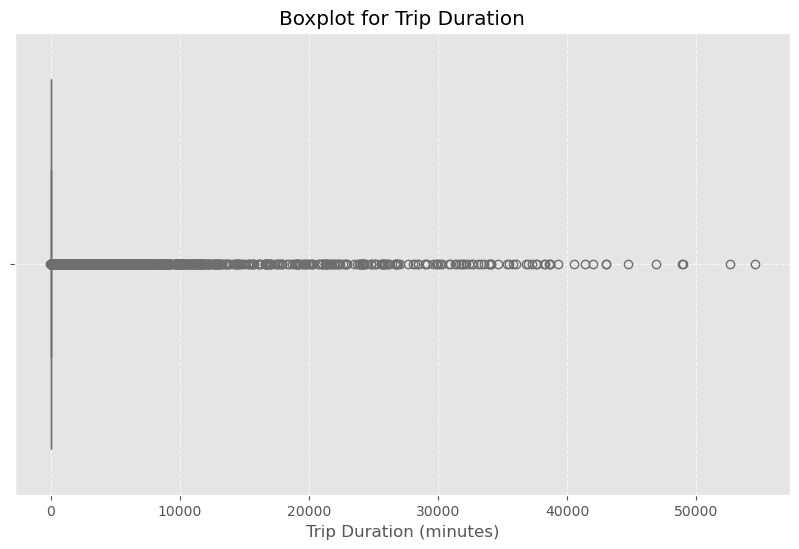

In [92]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot for the trip_duration column
sns.boxplot(x=df['trip_duration'], color='lightcoral')

# Adjust the layout and labels
plt.title('Boxplot for Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [93]:
df_filtered.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,16752,16752,"16,752.000000",0.000000,"16,752.000000","16,752.000000",0.000000,0.000000,"16,752.000000"
mean,2022-08-06 18:06:13.661353984,2022-08-07 21:20:30.740866816,"31,432.290652",<NA>,38.901020,-77.032678,NaN,NaN,"1,634.364136"
min,2021-01-01 09:30:20,2021-01-01 11:21:33,"30,200.000000",<NA>,38.782633,-77.368416,NaN,NaN,0.000000
25%,2021-11-10 17:29:19,2021-11-11 19:02:23.500000,"31,230.000000",<NA>,38.887378,-77.046570,NaN,NaN,768.000000
50%,2022-07-28 15:54:00,2022-07-29 09:34:19,"31,288.000000",<NA>,38.897857,-77.031617,NaN,NaN,"1,500.000000"
75%,2023-05-07 10:30:42.500000,2023-05-08 15:59:04,"31,628.000000",<NA>,38.910674,-77.012808,NaN,NaN,"1,500.000000"
max,2023-12-31 23:41:43,2024-01-02 00:41:36,"33,200.000000",<NA>,39.123513,-76.825535,NaN,NaN,"52,734.000000"
std,NaN,NaN,333.849929,<NA>,0.039717,0.047378,NaN,NaN,"2,420.212103"


* a ride logically may take less than 7 minutes (1st quartile) or exceed 20 minutes (3rd quartile) considering both downtown and urban areas of Washington DC.
* I will begin by checking with a minimum threshold of 1 minute to determine if the entries represent actual trips.

In [94]:
df_filtered = df[df['trip_duration'] == 1]
df_filtered

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
40,classic_bike,2021-01-01 00:53:45,2021-01-01 00:54:47,Rhode Island Ave Metro,31516,Rhode Island Ave Metro,31516,38.920682,-76.995876,38.920682,-76.995876,casual,1
99,classic_bike,2021-01-01 02:05:35,2021-01-01 02:06:31,11th & O St NW,31286,11th & O St NW,31286,38.908430,-77.027140,38.908430,-77.027140,member,1
259,classic_bike,2021-01-01 08:28:55,2021-01-01 08:29:59,M St & New Jersey Ave SE,31208,3rd & Tingey St SE,31634,38.876300,-77.003700,38.875010,-77.002400,member,1
285,electric_bike,2021-01-01 08:56:40,2021-01-01 08:57:13,NaN,<NA>,NaN,<NA>,38.920000,-76.980000,38.920000,-76.980000,casual,1
409,electric_bike,2021-01-01 10:35:39,2021-01-01 10:36:12,NaN,<NA>,NaN,<NA>,38.920000,-76.980000,38.920000,-76.980000,casual,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10674782,classic_bike,2023-12-31 23:25:16,2023-12-31 23:25:49,Calvert & Biltmore St NW,31106,Calvert & Biltmore St NW,31106,38.923203,-77.047637,38.923203,-77.047637,member,1
10674787,classic_bike,2023-12-31 23:25:52,2023-12-31 23:27:02,Calvert & Biltmore St NW,31106,Calvert & Biltmore St NW,31106,38.923203,-77.047637,38.923203,-77.047637,casual,1
10674829,classic_bike,2023-12-31 23:37:03,2023-12-31 23:37:43,Park Rd & Holmead Pl NW,31602,Park Rd & Holmead Pl NW,31602,38.930800,-77.031500,38.930800,-77.031500,casual,1
10674853,electric_bike,2023-12-31 23:40:44,2023-12-31 23:41:16,NaN,<NA>,NaN,<NA>,38.940000,-77.030000,38.940000,-77.030000,casual,1


In [95]:
df_filtered.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,139601,139601,"107,613.000000","104,231.000000","139,601.000000","139,601.000000","139,601.000000","139,601.000000","139,601.000000"
mean,2022-11-14 03:32:29.729414144,2022-11-14 03:33:30.631198720,"31,373.379415","31,375.578811",38.904460,-77.032654,38.904426,-77.032653,1.000000
min,2021-01-01 00:53:45,2021-01-01 00:54:47,"30,200.000000","30,200.000000",38.780000,-77.368431,38.780000,-77.370000,1.000000
25%,2022-04-12 17:16:34,2022-04-12 17:17:20,"31,208.000000","31,208.000000",38.890496,-77.044687,38.890496,-77.044780,1.000000
50%,2023-02-05 19:59:17,2023-02-05 20:00:43,"31,278.000000","31,280.000000",38.902993,-77.030000,38.902826,-77.030000,1.000000
75%,2023-08-03 19:17:13,2023-08-03 19:18:41,"31,612.000000","31,616.000000",38.918036,-77.013769,38.918036,-77.013769,1.000000
max,2023-12-31 23:56:07,2023-12-31 23:56:43,"33,200.000000","33,200.000000",39.125846,-76.825535,39.125828,-76.825535,1.000000
std,NaN,NaN,281.356296,281.472686,0.029550,0.034487,0.029539,0.034494,0.000000


* Rides at 1 minute duration seem to have mainly same start and end station names and locations.
* There are also missing values where geolocations accuracy is lower( with 2 decimals) 
* 1 minutes rides do not seem to be real rides

In [96]:
df_filtered = df[df['trip_duration'] == 3]
df_filtered.head(150).T

,4,17,26,58,63,87,89,118,124,132,150,165,168,189,191,205,224,227,234,250,252,282,289,292,301,323,344,361,373,379,395,429,430,435,449,466,487,506,513,528,543,546,600,631,662,715,739,744,790,823,837,840,861,872,942,1012,1030,1042,1053,1062,1071,1134,1190,1203,1233,1291,1305,1307,1319,1321,1327,1355,1383,1384,1385,1450,1468,1531,1555,1573,1593,1605,1650,1658,1683,1723,1733,1757,1765,1769,1854,1947,1963,1984,2041,2057,2089,2154,2162,2191,2255,2272,2361,2551,2561,2571,2586,2605,2821,2892,2942,3077,3091,3183,3242,3248,3287,3330,3390,3431,3483,3529,3580,3657,3669,3709,3844,3880,3909,3943,4087,4127,4201,4248,4286,4336,4339,4358,4367,4414,4433,4572,4603,4623,4700,4757,4768,4790,4890,4974
rideable_type,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,docked_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,docked_bike,docked_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,docked_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike
started_at,2021-01-01 00:17:46,2021-01-01 00:26:41,2021-01-01 00:36:37,2021-01-01 01:11:00,2021-01-01 01:12:22,2021-01-01 01:46:05,2021-01-01 01:46:14,2021-01-01 02:29:44,2021-01-01 02:35:52,2021-01-01 02:43:38,2021-01-01 03:45:20,2021-01-01 04:47:56,2021-01-01 05:02:27,2021-01-01 06:27:30,2021-01-01 06:31:33,2021-01-01 06:52:40,2021-01-01 07:35:26,2021-01-01 07:46:36,2021-01-01 07:58:30,2021-01-01 08:19:01,2021-01-01 08:21:17,2021-01-01 08:52:35,2021-01-01 08:59:44,2021-01-01 09:05:39,2021-01-01 09:13:58,2021-01-01 09:31:06,2021-01-01 09:45:39,2021-01-01 09:58:17,2021-01-01 10:06:21,2021-01-01 10:12:24,2021-01-01 10:23:59,2021-01-01 10:50:10,2021-01-01 10:50:54,2021-01-01 10:52:17,2021-01-01 10:59:44,2021-01-01 11:14:50,2021-01-01 11:35:53,2021-01-01 12:02:59,2021-01-01 12:11:13,2021-01-01 12:24:11,2021-01-01 12:45:10,2021-01-01 12:47:12,2021-01-01 13:31:56,2021-01-01 14:01:24,2021-01-01 14:16:48,2021-01-01 14:51:14,2021-01-01 15:10:10,2021-01-01 15:13:29,2021-01-01 16:02:35,2021-01-01 16:43:28,2021-01-01 17:19:26,2021-01-01 17:27:53,2021-01-01 18:41:34,2021-01-01 19:32:05,2021-01-01 23:23:14,2021-01-02 06:36:17,2021-01-02 07:06:23,2021-01-02 07:24:36,2021-01-02 07:38:14,2021-01-02 07:43:28,2021-01-02 07:53:10,2021-01-02 08:45:44,2021-01-02 09:08:44,2021-01-02 09:14:19,2021-01-02 09:29:29,2021-01-02 09:48:27

In [97]:
df_filtered.tail(150).T

,10672479,10672483,10672487,10672493,10672509,10672513,10672523,10672540,10672585,10672586,10672588,10672645,10672661,10672679,10672693,10672695,10672710,10672731,10672742,10672762,10672771,10672812,10672846,10672879,10672904,10672927,10672946,10672999,10673003,10673007,10673016,10673025,10673026,10673035,10673068,10673070,10673130,10673131,10673157,10673167,10673179,10673212,10673213,10673260,10673269,10673307,10673310,10673325,10673329,10673345,10673353,10673359,10673377,10673391,10673407,10673416,10673418,10673422,10673430,10673437,10673445,10673469,10673521,10673554,10673563,10673570,10673602,10673617,10673625,10673649,10673660,10673666,10673667,10673668,10673694,10673714,10673715,10673719,10673725,10673733,10673767,10673794,10673799,10673800,10673814,10673833,10673844,10673849,10673884,10673922,10673947,10673968,10673984,10673988,10674000,10674003,10674004,10674026,10674038,10674058,10674061,10674062,10674063,10674068,10674071,10674089,10674102,10674108,10674179,10674212,10674216,10674226,10674228,10674242,10674247,10674249,10674273,10674274,10674275,10674308,10674311,10674319,10674344,10674357,10674363,10674369,10674408,10674423,10674478,10674485,10674487,10674542,10674556,10674563,10674564,10674585,10674605,10674612,10674690,10674700,10674714,10674791,10674796,10674798,10674818,10674860,10674864,10674871,10674879,10674893
rideable_type,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike
started_at,2023-12-31 16:33:23,2023-12-31 16:33:39,2023-12-31 16:34:03,2023-12-31 16:34:33,2023-12-31 16:36:28,2023-12-31 16:37:03,2023-12-31 16:38:28,2023-12-31 16:39:18,2023-12-31 16:43:41,2023-12-31 16:43:43,2023-12-31 16:43:56,2023-12-31 16:48:14,2023-12-31 16:49:32,2023-12-31 16:51:01,2023-12-31 16:53:16,2023-12-31 16:53:35,2023-12-31 16:54:36,2023-12-31 16:56:54,2023-12-31 16:58:21,2023-12-31 17:00:24,2023-12-31 17:01:06,2023-12-31 17:06:23,2023-12-31 17:09:15,2023-12-31 17:12:17,2023-12-31 17:15:39,2023-12-31 17:17:59,2023-12-31 17:21:00,2023-12-31 17:26:24,2023-12-31 17:26:49,2023-12-31 17:27:3

In [98]:
df_filtered.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,396304,396304,"361,973.000000","356,476.000000","396,304.000000","396,304.000000","396,304.000000","396,304.000000","396,304.000000"
mean,2022-10-24 08:17:54.715271936,2022-10-24 08:20:56.352691456,"31,373.234418","31,378.616269",38.904568,-77.032202,38.904250,-77.032213,3.000000
min,2021-01-01 00:17:46,2021-01-01 00:21:00,"30,200.000000","30,200.000000",38.780000,-77.370000,38.780000,-77.370000,3.000000
25%,2022-03-06 09:51:26.249999872,2022-03-06 09:54:26.500000,"31,200.000000","31,201.000000",38.890612,-77.044767,38.891696,-77.044789,3.000000
50%,2022-11-28 08:23:49,2022-11-28 08:26:47,"31,279.000000","31,281.000000",38.903819,-77.031880,38.903040,-77.031737,3.000000
75%,2023-07-21 12:13:44.249999872,2023-07-21 12:16:45.750000128,"31,615.000000","31,616.000000",38.916857,-77.008911,38.915544,-77.008911,3.000000
max,2023-12-31 23:56:22,2023-12-31 23:59:14,"33,200.000000","33,200.000000",39.125854,-76.825535,39.125828,-76.820000,3.000000
std,NaN,NaN,274.972347,276.536160,0.028378,0.034830,0.028233,0.034680,0.000000


* 3 minutes rides have some real trips with consistent start and end location  with same or missing data
* but there are still many trips which do not seem to  be a real ride

In [99]:
df_filtered = df[df['trip_duration'] == 4]
df_filtered.head(150).T

,25,84,90,125,133,134,141,153,154,181,183,217,221,247,248,255,262,293,321,322,362,377,413,432,434,463,469,498,614,633,640,650,656,666,671,672,677,680,690,700,705,707,711,717,728,746,754,757,765,786,789,795,800,831,847,853,864,870,878,884,888,889,904,905,964,975,978,1003,1015,1020,1060,1138,1199,1240,1272,1282,1283,1295,1335,1339,1341,1346,1387,1449,1452,1539,1544,1551,1554,1628,1629,1661,1675,1763,1766,1771,1810,1857,1917,1953,1955,1978,2049,2054,2065,2119,2134,2198,2201,2243,2295,2302,2328,2457,2567,2587,2651,2656,2669,2846,2852,2874,2903,2907,2931,2932,2970,3012,3034,3134,3176,3265,3284,3323,3328,3348,3356,3377,3446,3521,3522,3645,3679,3684,3726,3745,3806,3815,3840,3898
rideable_type,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,docked_bike,classic_bike,classic_bike,classic_bike,docked_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,docked_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike
started_at,2021-01-01 00:36:10,2021-01-01 01:39:56,2021-01-01 01:50:06,2021-01-01 02:37:43,2021-01-01 02:44:49,2021-01-01 02:44:54,2021-01-01 03:08:19,2021-01-01 03:48:18,2021-01-01 03:51:16,2021-01-01 05:40:17,2021-01-01 06:09:40,2021-01-01 07:22:12,2021-01-01 07:27:26,2021-01-01 08:17:33,2021-01-01 08:18:42,2021-01-01 08:24:26,2021-01-01 08:31:46,2021-01-01 09:06:25,2021-01-01 09:29:52,2021-01-01 09:30:15,2021-01-01 09:58:31,2021-01-01 10:08:57,2021-01-01 10:41:15,2021-01-01 10:51:15,2021-01-01 10:52:05,2021-01-01 11:10:16,2021-01-01 11:15:56,2021-01-01 11:49:21,2021-01-01 13:49:21,2021-01-01 14:01:54,2021-01-01 14:06:51,2021-01-01 14:09:59,2021-01-01 14:13:41,2021-01-01 14:18:29,2021-01-01 14:22:04,2021-01-01 14:23:56,2021-01-01 14:30:43,2021-01-01 14:33:52,2021-01-01 14:38:10,2021-01-01 14:43:52,2021-01-01 14:47:59,2021-01-01 14:49:03,2021-01-01 14:50:54,2021-01-01 14:52:06,2021-01-01 15:04:54,2021-01-01 15:13:49,2021-01-01 15:23:14,2021-01-01 15:25:34,2021-01-01 15:33:52,2021-01-01 16:00:18,2021-01-01 16:01:20,2021-01-01 16:08:58,2021-01-01 16:13:33,2021-01-01 16:56:08,2021-01-01 17:39:18,2021-01-01 18:06:59,2021-01-01 18:58:33,2021-01-01 19:21:43,2021-01-01 20:18:37,2021-01-01 20:30:43,2021-01-01 20:39:21,2021-01-01 20:39:39,2021-01-01 21:48:35,2021-01-01 22:12:00,2021-01-02 00:34:08,2021-01-02 01:29:20,2021-

In [100]:
df_filtered.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,533819,533819,"494,275.000000","489,211.000000","533,819.000000","533,819.000000","533,819.000000","533,819.000000","533,819.000000"
mean,2022-10-17 11:19:54.986066176,2022-10-17 11:23:55.914866944,"31,374.320085","31,377.167629",38.905176,-77.031588,38.904711,-77.031530,4.000000
min,2021-01-01 00:36:10,2021-01-01 00:39:57,"30,200.000000","30,200.000000",38.780000,-77.370000,38.780000,-77.368416,4.000000
25%,2022-02-21 12:35:32.500000,2022-02-21 12:39:36.500000,"31,201.000000","31,201.000000",38.894841,-77.044400,38.894919,-77.044400,4.000000
50%,2022-11-13 16:31:54,2022-11-13 16:36:00,"31,278.000000","31,278.000000",38.905424,-77.031723,38.903827,-77.031686,4.000000
75%,2023-07-18 07:45:33,2023-07-18 07:49:54.500000,"31,613.000000","31,615.000000",38.916787,-77.008911,38.915544,-77.009888,4.000000
max,2023-12-31 23:58:27,2024-01-01 00:02:28,"33,200.000000","33,200.000000",39.130000,-76.825535,39.125828,-76.820000,4.000000
std,NaN,NaN,273.005474,273.046332,0.027349,0.034376,0.027174,0.034175,0.000000


In [101]:
df.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,10674902,10674902,"9,932,632.000000","9,880,567.000000","10,674,902.000000","10,674,902.000000","10,674,902.000000","10,674,902.000000","10,674,902.000000"
mean,2022-09-13 19:10:32.624763904,2022-09-13 19:30:55.487234048,"31,369.325435","31,370.861310",38.903308,-77.031870,38.902255,-77.031464,20.379917
min,2021-01-01 00:08:33,2021-01-01 00:21:00,"30,200.000000","30,200.000000",38.760000,-77.400000,0.000000,-77.560000,-68.000000
25%,2021-12-16 12:16:52.500000,2021-12-16 12:33:19.500000,"31,212.000000","31,214.000000",38.890539,-77.044603,38.890496,-77.044669,7.000000
50%,2022-09-22 09:25:45.500000,2022-09-22 09:41:24.500000,"31,278.000000","31,277.000000",38.902760,-77.031617,38.902314,-77.031500,11.000000
75%,2023-06-18 23:48:23.249999872,2023-06-19 00:15:01.750000128,"31,606.000000","31,609.000000",38.914751,-77.013667,38.912648,-77.012808,20.000000
max,2023-12-31 23:59:38,2024-01-01 15:24:35,"33,200.000000","33,200.000000",39.140000,-76.820000,39.190000,0.000000,"54,540.000000"
std,NaN,NaN,264.666758,265.009453,0.026818,0.033437,0.050498,0.091287,137.018161


* 4-minute duration seems to be a reasonable threshold for the minimum trip duration with consistent start and end locations and station names
* there are still rows with missing values on station names where geo location shows less accuracy,which I will check on next steps

In [102]:
df = df[df['trip_duration'] >= 4].reset_index(drop=True)
df.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646,Wilson Blvd & Ft Myer Dr,31015,38.880440,-77.025236,38.894600,-77.072305,member,25
1,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111,NaN,<NA>,38.917193,-77.025894,38.960000,-77.020000,casual,16
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214,14th & Belmont St NW,31119,38.912138,-77.038568,38.920870,-77.031691,member,14
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd & N Vermont St,31926,Wilson Blvd & N Vermont St,31926,38.879477,-77.114563,38.879477,-77.114563,member,6
4,electric_bike,2021-01-01 00:18:16,2021-01-01 00:29:05,NaN,<NA>,Georgia Ave & Kennedy St NW,31415,38.930000,-77.030000,38.956738,-77.027940,casual,11


In [103]:
df['trip_duration'].quantile(0.99)

136.0

In [104]:
df['trip_duration'].describe()

count   9,777,919.000000
mean           22.061587
std           143.047067
min             4.000000
25%             8.000000
50%            12.000000
75%            21.000000
max        54,540.000000
Name: trip_duration, dtype: float64

In [105]:
df_filtered = df[df['trip_duration'] > 136]
df_filtered.tail(150).T

,9756143,9756161,9756183,9756381,9756561,9757003,9757378,9757412,9757416,9757469,9757895,9757912,9757917,9757921,9758161,9758162,9758245,9758264,9758557,9758782,9758793,9758956,9759186,9759189,9759268,9759363,9759402,9759416,9759434,9759472,9759479,9759494,9759514,9759903,9760006,9760171,9760285,9760331,9760479,9760777,9760799,9761105,9761207,9762336,9762370,9762686,9762693,9762719,9762755,9762762,9762792,9762810,9762850,9762870,9762893,9762901,9762921,9762949,9763004,9764286,9764964,9765219,9765463,9765617,9765632,9765645,9765714,9765968,9766254,9766395,9766561,9766922,9766926,9767008,9767135,9767158,9767472,9767493,9767625,9767653,9767694,9767748,9767768,9767972,9768174,9768768,9768821,9768822,9768890,9769042,9769101,9769163,9769700,9769725,9769755,9769912,9769944,9770127,9770131,9770138,9770157,9770595,9770774,9771459,9771523,9771689,9771691,9772022,9772036,9772042,9772045,9772047,9772320,9772363,9772529,9772666,9772869,9772952,9772957,9773114,9773119,9773120,9773126,9773480,9773519,9773522,9774143,9774191,9774348,9774350,9774355,9774357,9774558,9774763,9774768,9774993,9775000,9775391,9775591,9776098,9776869,9777020,9777188,9777204,9777313,9777346,9777473,9777600,9777869,9777877
rideable_type,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike
started_at,2023-12-28 18:55:30,2023-12-28 18:57:57,2023-12-28 19:02:30,2023-12-28 19:34:37,2023-12-28 20:07:32,2023-12-28 21:55:19,2023-12-29 00:42:28,2023-12-29 01:23:52,2023-12-29 01:24:56,2023-12-29 02:31:00,2023-12-29 08:16:53,2023-12-29 08:19:38,2023-12-29 08:21:35,2023-12-29 08:22:22,2023-12-29 09:16:22,2023-12-29 09:16:47,2023-12-29 09:35:23,2023-12-29 09:37:53,2023-12-29 10:30:00,2023-12-29 11:05:19,2023-12-29 11:07:33,2023-12-29 11:25:42,2023-12-29 11:47:12,2023-12-29 11:47:17,2023-12-29 11:57:11,2023-12-29 12:07:37,2023-12-29 12:10:56,2023-12-29 12:12:55,2023-12-29 12:15:00,2023-12-29 12:18:25,2023-12-29 12:19:07,2023-12-29 12:20:50,2023-12-29 12:22:36,2023-12-29 13:01:09,2023-12-29 13:11:07,2023-12-29 13:27:49,2023-12-29 13:36:29,2023-12-29 13:41:38,2023-12-29 13:53:09,20

In [106]:
df_filtered.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,96810,96810,"93,941.000000","89,540.000000","96,810.000000","96,810.000000","96,810.000000","96,810.000000","96,810.000000"
mean,2022-07-22 20:38:47.115380480,2022-07-23 03:54:32.395506688,"31,369.719782","31,378.186029",38.897409,-77.037765,38.891572,-77.026421,435.757318
min,2021-01-01 00:47:55,2021-01-01 03:04:53,"30,200.000000","30,200.000000",38.780000,-77.390000,0.000000,-77.550000,137.000000
25%,2021-10-17 16:20:58.750000128,2021-10-18 07:34:40.500000,"31,225.000000","31,227.000000",38.888097,-77.048728,38.888097,-77.047318,155.000000
50%,2022-07-19 12:43:49.500000,2022-07-19 17:51:14.500000,"31,267.000000","31,269.000000",38.896104,-77.032687,38.896465,-77.032427,189.000000
75%,2023-04-23 15:17:54,2023-04-24 07:26:04,"31,517.000000","31,540.000000",38.905697,-77.019940,38.905470,-77.018677,302.000000
max,2023-12-31 23:40:20,2024-01-01 15:24:35,"33,200.000000","33,200.000000",39.125828,-76.825535,39.190000,0.000000,"54,540.000000"
std,NaN,NaN,298.777026,311.008285,0.032036,0.042793,0.451844,0.893671,"1,364.941089"


* up to the 0.99 quantile value, the duration is 136 minutes, and the values appear consistent.
* rides predominantly from casual users, who are likely using the service for holiday trips or longer rides.
* geo location statistics don’t provide much insight, as many trips ended at the same spot (which is expected).
* accuracy issue on geo locations is ongoing which causes missing values on station names
* finally removing the trips which are longer than 134 minutes 


In [107]:
df = df[df['trip_duration'] <= 136].reset_index(drop=True)
df.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646,Wilson Blvd & Ft Myer Dr,31015,38.880440,-77.025236,38.894600,-77.072305,member,25
1,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111,NaN,<NA>,38.917193,-77.025894,38.960000,-77.020000,casual,16
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214,14th & Belmont St NW,31119,38.912138,-77.038568,38.920870,-77.031691,member,14
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd & N Vermont St,31926,Wilson Blvd & N Vermont St,31926,38.879477,-77.114563,38.879477,-77.114563,member,6
4,electric_bike,2021-01-01 00:18:16,2021-01-01 00:29:05,NaN,<NA>,Georgia Ave & Kennedy St NW,31415,38.930000,-77.030000,38.956738,-77.027940,casual,11


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9681109 entries, 0 to 9681108
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rideable_type       category      
 1   started_at          datetime64[ns]
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   start_station_id    Int64         
 5   end_station_name    object        
 6   end_station_id      Int64         
 7   start_lat           float64       
 8   start_lng           float64       
 9   end_lat             float64       
 10  end_lng             float64       
 11  member_casual       object        
 12  trip_duration       int32         
dtypes: Int64(2), category(1), datetime64[ns](2), float64(4), int32(1), object(3)
memory usage: 877.1+ MB


In [109]:
df.isna().sum()


rideable_type              0
started_at                 0
ended_at                   0
start_station_name    621837
start_station_id      621837
end_station_name      646658
end_station_id        646658
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
trip_duration              0
dtype: int64

* the values and stats from the features have been reviewed, but before proceeding to the analysis, I want to ensure the accuracy of the geo locations.

    * 0 Decimal Places=	1.0	111 km
    * 1 Decimal Places=	0.1	11.1 km
    * 2 Decimal Places=	0.01	1.11 km
    * 3 Decimal Places=	0.001	111 m
    * 4 Decimal Places=	0.0001	11.1 m
    * 5 Decimal Places=	0.00001	1.11 m

* It can give inaccurate location results if we have 3 or fewer decimal places in the geo-location values.


In [110]:
# Function to check if a coordinate has 2 or more trailing zeros after the decimal point
def check_precision(value):
    # Multiply by 100 to make less accurate values integer
    return round(value * 100) == value * 100

# Filter rows where any of the latitudes or longitudes have 2 or more trailing zeros
df_filtered_inaccurate = df[
    df[['start_lat', 'start_lng', 'end_lat', 'end_lng']].apply(
        lambda row: any(check_precision(val) for val in row), axis=1
    )
]

df_filtered_inaccurate

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111,NaN,<NA>,38.917193,-77.025894,38.960000,-77.020000,casual,16
4,electric_bike,2021-01-01 00:18:16,2021-01-01 00:29:05,NaN,<NA>,Georgia Ave & Kennedy St NW,31415,38.930000,-77.030000,38.956738,-77.027940,casual,11
6,electric_bike,2021-01-01 00:20:40,2021-01-01 00:35:36,Columbia Rd & Georgia Ave NW,31115,NaN,<NA>,38.928081,-77.023768,38.900000,-77.020000,casual,15
17,electric_bike,2021-01-01 00:27:18,2021-01-01 00:34:30,NaN,<NA>,NaN,<NA>,38.990000,-77.030000,38.990000,-77.030000,member,7
18,electric_bike,2021-01-01 00:28:39,2021-01-01 00:41:31,Connecticut Ave & Macomb St NW / Cleveland Park,31305,NaN,<NA>,38.934253,-77.058010,38.920000,-77.070000,member,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681086,electric_bike,2023-12-31 23:47:39,2023-12-31 23:51:47,Friendship Blvd & Willard Ave,32040,NaN,<NA>,38.961228,-77.088635,38.960000,-77.070000,casual,4
9681087,electric_bike,2023-12-31 23:47:46,2023-12-31 23:59:18,14th & L St NW,31283,NaN,<NA>,38.903728,-77.031661,38.900000,-77.020000,member,12
9681093,electric_bike,2023-12-31 23:51:14,2023-12-31 23:59:49,NaN,<NA>,NaN,<NA>,38.910000,-77.020000,38.920000,-77.040000,member,9
9681100,electric_bike,2023-12-31 23:54:07,2024-01-01 00:01:39,Fort Totten Metro,31515,NaN,<NA>,38.952364,-77.002654,38.960000,-76.980000,member,8


In [117]:
df_sample = df_filtered_inaccurate.sample(n=100, random_state=42)
df_sample.head(100).T

,7038818,8789951,2851822,8085914,8555300,3418705,760595,8975824,9444709,3308927,223378,9394209,8355652,4642324,6692213,5104174,3140909,132635,3348680,8558435,583671,8842278,5400102,8479130,1611712,6700899,3001991,2175766,7671714,1887844,8175381,1696521,7475707,5052680,7453615,9613447,6600531,2372082,313364,2434674,7288668,8310178,9674208,2497695,759976,9212896,5121274,89211,4710633,4771516,6434749,8701664,6178277,4947837,6846198,6878318,2230311,987719,9244176,8567863,8919432,6287384,871545,1386527,6061138,1339416,8178575,7310613,9245228,9631786,685768,4177970,717847,2995110,6865495,8119865,8863976,612517,9462442,8661925,879165,9610824,7009345,6375725,7426875,6836322,9196131,800302,9524460,2225373,3929224,9418762,7639969,1456431,8738647,7259907,3069826,9399075,9034406,1553283
rideable_type,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike
started_at,2023-05-30 08:09:11,2023-10-08 08:31:39,2022-03-15 07:57:01,2023-08-17 19:16:43,2023-09-20 17:50:51,2022-05-16 15:40:28,2021-06-02 15:21:47,2023-10-22 00:29:06,2023-12-01 18:47:06,2022-05-04 07:57:45,2021-03-14 13:53:16,2023-11-25 13:34:16,2023-09-06 10:06:29,2022-08-31 19:01:39,2023-05-02 17:02:01,2022-10-12 18:08:06,2022-04-16 18:12:21,2021-02-19 12:48:50,2022-05-09 19:01:24,2023-09-20 20:06:22,2021-05-10 18:46:35,2023-10-12 07:31:19,2022-11-10 06:38:14,2023-09-15 11:06:00,2021-09-08 13:40:17,2023-05-03 15:36:33,2022-04-01 18:42:24,2021-11-06 15:32:45,2023-07-17 20:59:57,2021-10-06 19:52:05,2023-08-24 08:38:59,2021-09-17 14:53:20,2023-07-03 11:42:52,2022-10-08 00:13:07,2023-07-01 12:51:24,2023-12-20 02:46:07,2023-04-23 13:35:32,2021-12-03 17:41:33,2021-03-30 18:27:18,2021-12-12 19:32:30,2023-06-17 17:06:42,2023-09-02 18:14:55,2023-12-30 20:32:12,2021-12-25 11:19:42,2021-06-02 13:59:37,2023-11-07 20:07:06,2022-10-14 16:59:10,2021-01-30 18:37:42,2022-09-06 22:03:23,2022-09-12 10:39:33,2023-04-10 13:00:51,2023-10-01 23:10:41,2023-03-16 22:27:40,2022-09-26 15:27:57,2023-05-15 09:39:39,2023-05-17 18:34:43,2021-11-12 12:08:46,2021-06-28 21:35:35,2023-11-10 14:51:44,2023-09-21 16:40:37,2023-10-18 07:50:59,2023-03-28 13:27:26,2021-06-16 14:33:02,2021-08-12 18:32:10,2023-02-28 15:31:08,2021-08-06 17:20:44,2023-08-24 13:46:38,2023-06-19 11:31:15,2023-11-10 16:40:40,2023-12-22 14:14:19,2021-05-22 18:45:51,2022-07-20 21:23:26,2021-05-27 12:34:47,2022-03-31 22:03:21,2023-05-16 18:39:11,2023-08-20 07:30:38,2023-10-13 15:02:27,2021-05-14 17:41:58,2023-12-03 15:36:50,2023-09-29 16:10:46,2021-06-17 11:00:34,2023-12-19 17:21:21,2023-05-27 13:23:11,2023-04-05 08:22:59,2023-06-29 08:38:55,2023-05-14 14:08:39,2023-11-06 17:07:47,2021-06-07 08:36:59,2023-12-09 15:25:52,2021-11-11

In [118]:
df['rideable_type'].value_counts()

rideable_type
classic_bike     7018175
electric_bike    2167443
docked_bike       495491
Name: count, dtype: int64

In [119]:
df_filtered_inaccurate['rideable_type'].value_counts()

rideable_type
electric_bike    844135
classic_bike       3939
docked_bike           0
Name: count, dtype: int64

In [115]:
df_filtered_inaccurate['member_casual'].value_counts()

member_casual
member    518427
casual    329647
Name: count, dtype: int64

In [114]:
df_filtered_inaccurate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 848074 entries, 1 to 9681108
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   rideable_type       848074 non-null  category      
 1   started_at          848074 non-null  datetime64[ns]
 2   ended_at            848074 non-null  datetime64[ns]
 3   start_station_name  271077 non-null  object        
 4   start_station_id    271077 non-null  Int64         
 5   end_station_name    249539 non-null  object        
 6   end_station_id      249539 non-null  Int64         
 7   start_lat           848074 non-null  float64       
 8   start_lng           848074 non-null  float64       
 9   end_lat             848074 non-null  float64       
 10  end_lng             848074 non-null  float64       
 11  member_casual       848074 non-null  object        
 12  trip_duration       848074 non-null  int32         
dtypes: Int64(2), category(1), datetim

* despite most of the rides in the dataset being made with classic bikes, there is a majority of electric bike rides here. 
* of the 2167443 e-bike rides, 848074 (% 39)have accuracy issues, with a minimum error of 100 meters
* my guess, e-bikes do not have be locked to a dock(station)
* this also explains why we had many missing station names and locations on previous step about outliers
* decision: it is almost % 40 of e bike rides so I keep them as they are and go to analysis step. 

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9681109 entries, 0 to 9681108
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rideable_type       category      
 1   started_at          datetime64[ns]
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   start_station_id    Int64         
 5   end_station_name    object        
 6   end_station_id      Int64         
 7   start_lat           float64       
 8   start_lng           float64       
 9   end_lat             float64       
 10  end_lng             float64       
 11  member_casual       object        
 12  trip_duration       int32         
dtypes: Int64(2), category(1), datetime64[ns](2), float64(4), int32(1), object(3)
memory usage: 877.1+ MB


* during the cleaning phase, the number of rows decreased from 10,693,997 to 9,681,109, which is approximately 9.47% of the total as 1,012,888 entries.

# 2: EDA<a id="2"></a>